# Evaluation of Machine Learning Models for Zillow/AirBNB Datasets <a id='home'></a>

There are 4 sections to this document:
1. [Comparing models](#comparing_models)
2. [Using selected model to make predictions](#prediction_tool)
3. [Linear Regression on Occupancy Rate](#lr_occrate)
4. [Property Recommendations](#prop_recs)

# Section 1 - Comparing Models <a id='comparing_models'></a>
To return to the top of the notebook, click [here](#home).

### Regression vs Classification Models

If conducting supervised learning on these datasets, we will need to use a regression model. The data we are looking at is continuous data, which requires regression mdoeling. Logistic modeling is discreet and would not be applicable for this dataset.

### Comparing Regression Models
We will test:
* [Multivariate Linear Regression](#mv_lr)
* [SVM Regression](#svm)
* [Random Forest Regression](#rf)
* [Decision Tree](#dt)

Conclusion: The model with the best fit for the Zillow data was the Random Forest Model. The model with the best fit for the AirBNB data was the Multivariate Linear Regression. See [Model Conclusion](#model_conclusion) for more details.

## Prepare the data for the models

In [1]:
# import dependencies
import pandas as pd
import numpy as np
from datetime import datetime

# visualization dependencies
import seaborn as sb
%matplotlib inline
import matplotlib.pyplot as plt

import sqlite3
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

#modeling dependencies
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import statsmodels.api as sm
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
con_zlw = sqlite3.connect("../finalprojectdatabase.db")
zlw_original = pd.read_sql_query("SELECT * from zillow_google", con_zlw)

con_airbnb = sqlite3.connect("../finalprojectdatabase.db")
airbnb_original = pd.read_sql_query("SELECT * from arbnb_google", con_airbnb)

In [3]:
zlw_original.head()

,Address,City,Zipcode,bathrooms,bedrooms,daysOnZillow,homeType,latitude,livingArea,longitude,...,taxAssessedYear,url,yearBuilt,house_number,street_name,google_zip,google_neighborhood,lat_lng,zipcode_length,google_address
0,1121 SW 10th Dr,Gresham,97080,3.0,4.0,11.0,SINGLE_FAMILY,45.488228,2724.0,-122.444420,...,2020-01-01,https://www.zillow.com/homedetails/1121-SW-10t...,1982-01-01,1131,Southwest Florence Drive,97080,Gresham Butte,"45.48822784, -122.4444199",5,1131 Southwest Florence Drive
1,19309 NE Glisan St,Portland,97230,1.0,3.0,11.0,SINGLE_FAMILY,45.526634,1217.0,-122.464088,...,2017-01-01,https://www.zillow.com/homedetails/19309-NE-Gl...,1953-01-01,19309,Northeast Glisan Street,97230,North Gresham,"45.52663422, -122.4640884",5,19309 Northeast Glisan Street
2,1518 SE 12th St,Gresham,97080,2.0,3.0,14.0,SINGLE_FAMILY,45.487991,1150.0,-122.416184,...,2020-01-01,https://www.zillow.com/homedetails/1518-SE-12t...,1967-01-01,1518,Southeast 12th Street,97080,Asert,"45.48799133, -122.4161835",5,1518 Southeast 12th Street
3,110 NW Willowbrook Ct,Gresham,97030,2.0,3.0,25.0,SINGLE_FAMILY,45.498184,2036.0,-122.451332,...,2020-01-01,https://www.zillow.com/homedetails/110-NW-Will...,1978-01-01,110,Northwest Willowbrook Court,97030,Northwest,"45.4981842, -122.4513321",5,110 Northwest Willowbrook Court
4,3569 SW Mckinley St,Gresham,97080,3.0,3.0,41.0,SINGLE_FAMILY,45.475353,2209.0,-122.468307,...,2020-01-01,https://www.zillow.com/homedetails/3569-SW-Mck...,2017-01-01,3569,Southwest McKinley Street,97080,Pleasant Valley,"45.47535324, -122.4683075",5,3569 Southwest McKinley Street


In [4]:
# set address as index
zlw_original = zlw_original.set_index('google_address', drop=True)
print(zlw_original.columns.to_list())
zlw_original

['Address', 'City', 'Zipcode', 'bathrooms', 'bedrooms', 'daysOnZillow', 'homeType', 'latitude', 'livingArea', 'longitude', 'lotSize', 'date_sold', 'price', 'pricePerSquareFoot', 'rentZestimate', 'taxAssessedValue', 'taxAssessedYear', 'url', 'yearBuilt', 'house_number', 'street_name', 'google_zip', 'google_neighborhood', 'lat_lng', 'zipcode_length']


,Address,City,Zipcode,bathrooms,bedrooms,daysOnZillow,homeType,latitude,livingArea,longitude,...,taxAssessedValue,taxAssessedYear,url,yearBuilt,house_number,street_name,google_zip,google_neighborhood,lat_lng,zipcode_length
google_address,,,,,,,,,,,,,,,,,,,,,
1131 Southwest Florence Drive,1121 SW 10th Dr,Gresham,97080,3.0,4.0,11.0,SINGLE_FAMILY,45.488228,2724.0,-122.444420,...,397560.0,2020-01-01,https://www.zillow.com/homedetails/1121-SW-10t...,1982-01-01,1131,Southwest Florence Drive,97080,Gresham Butte,"45.48822784, -122.4444199",5
19309 Northeast Glisan Street,19309 NE Glisan St,Portland,97230,1.0,3.0,11.0,SINGLE_FAMILY,45.526634,1217.0,-122.464088,...,269520.0,2017-01-01,https://www.zillow.com/homedetails/19309-NE-Gl...,1953-01-01,19309,Northeast Glisan Street,97230,North Gresham,"45.52663422, -122.4640884",5
1518 Southeast 12th Street,1518 SE 12th St,Gresham,97080,2.0,3.0,14.0,SINGLE_FAMILY,45.487991,1150.0,-122.416184,...,309260.0,2020-01-01,https://www.zillow.com/homedetails/1518-SE-12t...,1967-01-01,1518,Southeast 12th Street,97080,Asert,"45.48799133, -122.4161835",5
110 Northwest Willowbrook Court,110 NW Willowbrook Ct,Gresham,97030,2.0,3.0,25.0,SINGLE_FAMILY,45.498184,2036.0,-122.451332,...,373030.0,2020-01-01,https://www.zillow.com/homedetails/110-NW-Will...,1978-01-01,110,Northwest Willowbrook Court,97030,Northwest,"45.4981842, -122.4513321",5
3569 Southwest McKinley Street,3569 SW Mckinley St,Gresham,97080,3.0,3.0,41.0,SINGLE_FAMILY,45.475353,2209.0,-122.468307,...,453610.0,2020-01-01,https://www.zillow.com/homedetails/3569-SW-Mck...,2017-01-01,3569,Southwest McKinley Street,97080,Pleasant Valley,"45.47535324, -122.4683075",5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15455 Southwest Gleneden Drive,15455 SW Gleneden Dr,Beaverton,97007,3.0,4.0,357.0,SINGLE_FAMILY,45.463707,2145.0,-122.835503,...,484840.0,2019-01-01,https://www.zillow.com/homedetails/15455-SW-Gl...,1989-01-01,15455,Southwest Gleneden Drive,97007,Sexton Mountain,"45.46370697, -122.8355026",5
7210 Southwest 156th Avenue,7210 SW 156th Ave,Beaverton,97007,2.0,3.0,360.0,SINGLE_FAMILY,45.467113,1752.0,-122.837746,...,402690.0,2019-01-01,https://www.zillow.com/homedetails/7210-SW-156...,1991-01-01,7210,Southwest 156th Avenue,97007,West Beaverton,"45.46711349, -122.8377457",5
7050 Southwest 152nd Avenue,7050 SW 152nd Ave,Beaverton,97007,2.0,3.0,360.0,SINGLE_FAMILY,45.468781,1924.0,-122.833855,...,410120.0,2019-01-01,https://www.zillow.com/homedetails/7050-SW-152...,1981-01-01,7050,Southwest 152nd Avenue,97007,West Beaverton,"45.46878052, -122.8338547",5


<AxesSubplot:>

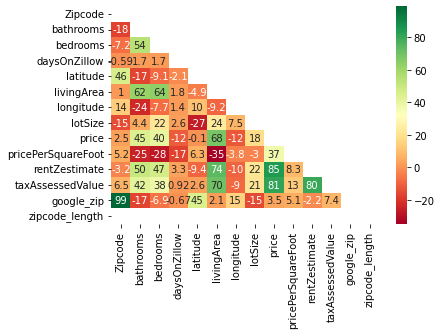

In [5]:
# correlation heatmap
mask = np.zeros_like(zlw_original.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# heatmap
sb.heatmap(zlw_original.corr()*100, 
           cmap='RdYlGn', 
           annot = True, 
           mask = mask)

In [6]:
# drop columns not needed for machine learning
zlw = zlw_original.drop(['Address',
                'City',
                'Zipcode',
                #'bathrooms',
                #'bedrooms',
                #'daysOnZillow',
                #'homeType',
                'latitude',
                #'livingArea',
                'longitude',
                #'lotSize',
                'date_sold',
                #'price',
                #'pricePerSquareFoot',
                #'rentZestimate',
                #'taxAssessedValue',
                #'taxAssessedYear',
                'url',
                #'yearBuilt',
                'house_number',
                'street_name',
                #'google_zip',
                #'google_neighborhood',
                'lat_lng',
                'zipcode_length'], axis=1)
zlw.dtypes

bathrooms              float64
bedrooms               float64
daysOnZillow           float64
homeType                object
livingArea             float64
lotSize                float64
price                    int64
pricePerSquareFoot     float64
rentZestimate          float64
taxAssessedValue       float64
taxAssessedYear         object
yearBuilt               object
google_zip               int64
google_neighborhood     object
dtype: object

<AxesSubplot:>

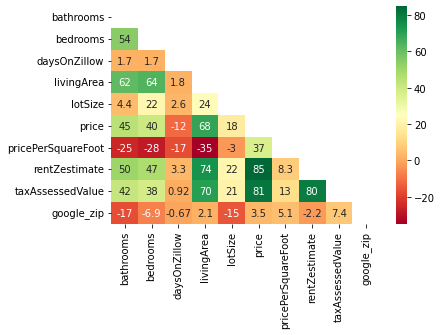

In [7]:
# correlation heatmap
mask = np.zeros_like(zlw.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# heatmap
sb.heatmap(zlw.corr()*100, 
           cmap='RdYlGn', 
           annot = True, 
           mask = mask)

In [8]:
airbnb_original.head()

,listing_url,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,...,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,house_number,street_name,google_zip,google_neighborhood,lat_lng,google_address
0,https://www.airbnb.com/rooms/12899,within an hour,100.0,100.0,1,0,Concordia,45.56488,-122.63418,Entire home/apt,...,4.99,4.93,4.94,4.08,5827,Northeast 31st Avenue,97211,Concordia,"45.56488, -122.63418",5827 Northeast 31st Avenue
1,https://www.airbnb.com/rooms/37676,within a day,100.0,55.0,1,1,Pearl,45.52564,-122.68273,Entire home/apt,...,4.77,4.94,4.66,0.91,1110,Northwest Flanders Street,97209,Northwest Portland,"45.52564, -122.68273",1110 Northwest Flanders Street
2,https://www.airbnb.com/rooms/41601,within an hour,100.0,100.0,1,1,Roseway,45.54804,-122.58541,Entire home/apt,...,4.92,4.67,4.83,1.76,7510,Northeast Fremont Street,97213,Roseway,"45.54804, -122.58541",7510 Northeast Fremont Street
3,https://www.airbnb.com/rooms/61893,within an hour,100.0,73.0,1,1,Goose Hollow,45.52258,-122.69955,Entire home/apt,...,5.00,5.00,4.93,0.24,2334,Southwest Cactus Drive,97205,Goose Hollow,"45.52258, -122.69955",2334 Southwest Cactus Drive
4,https://www.airbnb.com/rooms/80357,within an hour,100.0,52.0,1,1,Sullivan's Gulch,45.53364,-122.63895,Entire home/apt,...,5.00,5.00,5.00,0.02,2608,Northeast Halsey Street,97232,Sullivan's Gulch,"45.53364, -122.63895",2608 Northeast Halsey Street


In [9]:
# set address as index
airbnb_original = airbnb_original.set_index('google_address', drop=True)
print(airbnb_original.columns.to_list())
airbnb_original.head()

['listing_url', 'host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_identity_verified', 'neighbourhood_cleansed', 'latitude', 'longitude', 'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'price', 'minimum_nights', 'maximum_nights', 'number_of_reviews_l30d', 'last_review', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month', 'house_number', 'street_name', 'google_zip', 'google_neighborhood', 'lat_lng']


,listing_url,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_identity_verified,neighbourhood_cleansed,latitude,longitude,room_type,...,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,house_number,street_name,google_zip,google_neighborhood,lat_lng
google_address,,,,,,,,,,,,,,,,,,,,,
5827 Northeast 31st Avenue,https://www.airbnb.com/rooms/12899,within an hour,100.0,100.0,1,0,Concordia,45.56488,-122.63418,Entire home/apt,...,4.99,4.99,4.93,4.94,4.08,5827,Northeast 31st Avenue,97211,Concordia,"45.56488, -122.63418"
1110 Northwest Flanders Street,https://www.airbnb.com/rooms/37676,within a day,100.0,55.0,1,1,Pearl,45.52564,-122.68273,Entire home/apt,...,4.83,4.77,4.94,4.66,0.91,1110,Northwest Flanders Street,97209,Northwest Portland,"45.52564, -122.68273"
7510 Northeast Fremont Street,https://www.airbnb.com/rooms/41601,within an hour,100.0,100.0,1,1,Roseway,45.54804,-122.58541,Entire home/apt,...,4.95,4.92,4.67,4.83,1.76,7510,Northeast Fremont Street,97213,Roseway,"45.54804, -122.58541"
2334 Southwest Cactus Drive,https://www.airbnb.com/rooms/61893,within an hour,100.0,73.0,1,1,Goose Hollow,45.52258,-122.69955,Entire home/apt,...,4.93,5.00,5.00,4.93,0.24,2334,Southwest Cactus Drive,97205,Goose Hollow,"45.52258, -122.69955"
2608 Northeast Halsey Street,https://www.airbnb.com/rooms/80357,within an hour,100.0,52.0,1,1,Sullivan's Gulch,45.53364,-122.63895,Entire home/apt,...,5.00,5.00,5.00,5.00,0.02,2608,Northeast Halsey Street,97232,Sullivan's Gulch,"45.53364, -122.63895"


<AxesSubplot:>

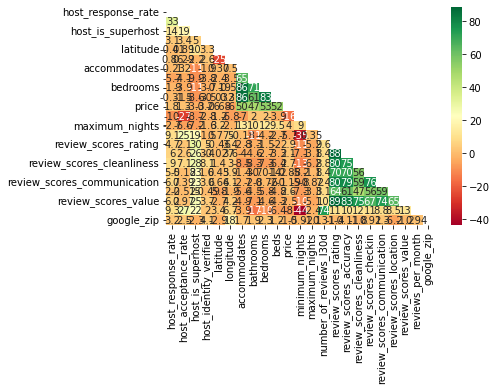

In [10]:
# correlation heatmap
mask = np.zeros_like(airbnb_original.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# heatmap
sb.heatmap(airbnb_original.corr()*100, 
           cmap='RdYlGn', 
           annot = True, 
           mask = mask)

In [11]:
# drop columns not needed for machine learning
airbnb = airbnb_original.drop(['listing_url',
                       #'host_response_time',
                       #'host_response_rate',
                       #'host_acceptance_rate',
                       #'host_is_superhost',
                       #'host_identity_verified',
                       'neighbourhood_cleansed',
                       'latitude',
                       'longitude',
                       #'room_type',
                       #'accommodates',
                       #'bathrooms',
                       #'bedrooms',
                       #'beds',
                       #'price',
                       #'minimum_nights',
                       #'maximum_nights',
                       #'number_of_reviews_l30d',
                       'last_review',
                       #'review_scores_rating',
                       #'review_scores_accuracy',
                       #'review_scores_cleanliness',
                       #'review_scores_checkin',
                       #'review_scores_communication',
                       #'review_scores_location',
                       #'review_scores_value',
                       #'reviews_per_month',
                       'house_number',
                       'street_name',
                       #'google_zip',
                       #'google_neighborhood',
                       'lat_lng'], axis=1)
airbnb.dtypes

host_response_time              object
host_response_rate             float64
host_acceptance_rate           float64
host_is_superhost                int64
host_identity_verified           int64
room_type                       object
accommodates                     int64
bathrooms                      float64
bedrooms                       float64
beds                           float64
price                          float64
minimum_nights                   int64
maximum_nights                   int64
number_of_reviews_l30d           int64
review_scores_rating           float64
review_scores_accuracy         float64
review_scores_cleanliness      float64
review_scores_checkin          float64
review_scores_communication    float64
review_scores_location         float64
review_scores_value            float64
reviews_per_month              float64
google_zip                       int64
google_neighborhood             object
dtype: object

<AxesSubplot:>

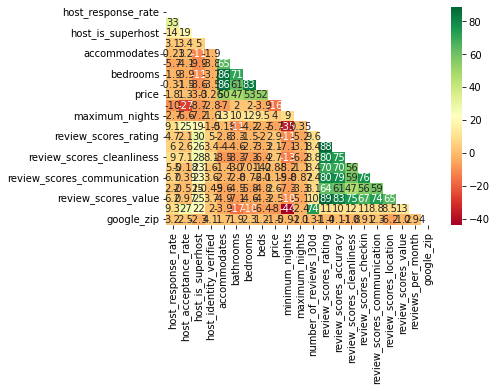

In [12]:
# correlation heatmap
mask = np.zeros_like(airbnb.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# heatmap
sb.heatmap(airbnb.corr()*100, 
           cmap='RdYlGn', 
           annot = True, 
           mask = mask)

In [13]:
# drop airbnb columns not in zillow dataset so that we can apply zillow data to airbnb ML model later
airbnb = airbnb[['bathrooms', 'bedrooms', 'google_zip', 'google_neighborhood', 'price']]
airbnb.head()

,bathrooms,bedrooms,google_zip,google_neighborhood,price
google_address,,,,,
5827 Northeast 31st Avenue,1.0,2.0,97211,Concordia,89.0
1110 Northwest Flanders Street,1.0,1.0,97209,Northwest Portland,14.0
7510 Northeast Fremont Street,1.0,1.0,97213,Roseway,129.0
2334 Southwest Cactus Drive,1.0,1.0,97205,Goose Hollow,104.0
2608 Northeast Halsey Street,1.0,1.0,97232,Sullivan's Gulch,9.0


<AxesSubplot:>

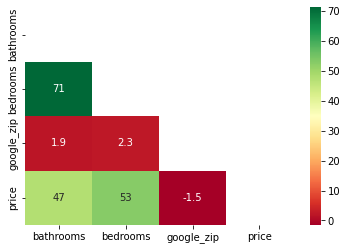

In [14]:
# correlation heatmap
mask = np.zeros_like(airbnb.corr(), dtype=np.bool_)
mask[np.triu_indices_from(mask)] = True

# heatmap
sb.heatmap(airbnb.corr()*100, 
           cmap='RdYlGn', 
           annot = True, 
           mask = mask)

### Test OneHotEncoder vs Label Encoding
To return to the top of the notebook, click [here](#home).

Conclusion: Label Encoding returned a better result for the linear regression. Will use LE and not OHE for the other models.

In [15]:
le = LabelEncoder()
# ohe = OneHotEncoder(sparse=False)

In [16]:
# set columns to check to list

In [17]:
zlw_le = zlw.copy()
# zlw_ohe = zlw.copy()
airbnb_le = airbnb.copy()
# airbnb_ohe = airbnb.copy()

In [18]:
zlw_cat_col = zlw.select_dtypes(include='object').columns
airbnb_cat_col = airbnb.select_dtypes(include=['object']).columns

In [19]:
#Label Encoder
for row in zlw_cat_col:
    zlw_le[row] = le.fit_transform(zlw_le[row].astype(str))

for row in airbnb_cat_col:
    airbnb_le[row] = le.fit_transform(airbnb_le[row].astype(str))

In [20]:
zlw_le.head()

,bathrooms,bedrooms,daysOnZillow,homeType,livingArea,lotSize,price,pricePerSquareFoot,rentZestimate,taxAssessedValue,taxAssessedYear,yearBuilt,google_zip,google_neighborhood
google_address,,,,,,,,,,,,,,
1131 Southwest Florence Drive,3.0,4.0,11.0,3,2724.0,9583.0,512000,188.0,1995.0,397560.0,4,102,97080,51
19309 Northeast Glisan Street,1.0,3.0,11.0,3,1217.0,13939.0,348000,286.0,1695.0,269520.0,1,73,97230,99
1518 Southeast 12th Street,2.0,3.0,14.0,3,1150.0,7000.0,404200,351.0,1800.0,309260.0,4,87,97080,6
110 Northwest Willowbrook Court,2.0,3.0,25.0,3,2036.0,6969.0,478200,235.0,2250.0,373030.0,4,98,97030,107
3569 Southwest McKinley Street,3.0,3.0,41.0,3,2209.0,5227.0,550000,249.0,2300.0,453610.0,4,137,97080,120


In [21]:
airbnb_le.head()

,bathrooms,bedrooms,google_zip,google_neighborhood,price
google_address,,,,,
5827 Northeast 31st Avenue,1.0,2.0,97211,8,89.0
1110 Northwest Flanders Street,1.0,1.0,97209,37,14.0
7510 Northeast Fremont Street,1.0,1.0,97213,45,129.0
2334 Southwest Cactus Drive,1.0,1.0,97205,16,104.0
2608 Northeast Halsey Street,1.0,1.0,97232,51,9.0


In [22]:
#OneHotEncoder - get dummies
# zlw_dum = pd.get_dummies(zlw_ohe, columns = zlw_cat_col)
# airbnb_dum = pd.get_dummies(airbnb_ohe, columns = airbnb_cat_col)

In [23]:
# zlw_dum.head()

In [24]:
# airbnb_dum.head()

## Multivariate Linear Regression Model <a id='mv_lr'></a>
To return to the top of the notebook, click [here](#home).

Conclusion: MinMaxScaler and StandardScaler returned the same output. Will use StandardScaler. OHE returned a much less accurate model than label encoding. Will use label encoding for categorical columns.

#### Set variables & perform scaling

In [25]:
std_scaler = StandardScaler()
# minmax_scaler = MinMaxScaler()

In [26]:
#Standard Scaler Variables
# LE
y_zlw_le_std = zlw_le.price
X_zlw_le_std = zlw_le.drop('price', axis=1)

y_airbnb_le_std = airbnb_le.price
X_airbnb_le_std = airbnb_le.drop('price', axis=1)

# # OHE
# y_zlw_ohe_std = zlw_dum.price
# X_zlw_ohe_std = zlw_dum.drop('price', axis=1)

# y_airbnb_ohe_std = airbnb_dum.price
# X_airbnb_ohe_std = airbnb_dum.drop('price', axis=1)

In [27]:
# # MinMax Scaler Variables
# # LE
# y_zlw_le_minmax = zlw_le.price
# X_zlw_le_minmax = zlw_le.drop('price', axis=1)

# y_airbnb_le_minmax = airbnb_le.price
# X_airbnb_le_minmax = airbnb_le.drop('price', axis=1)

# # OHE
# y_zlw_ohe_minmax = zlw_dum.price
# X_zlw_ohe_minmax = zlw_dum.drop('price', axis=1)

# y_airbnb_ohe_minmax = airbnb_dum.price
# X_airbnb_ohe_minmax = airbnb_dum.drop('price', axis=1)

In [28]:
# fit and transform the X data - StandardScaler

# LE
X_zlw_le_std[X_zlw_le_std.columns] = std_scaler.fit_transform(X_zlw_le_std[X_zlw_le_std.columns].values)
X_airbnb_le_std[X_airbnb_le_std.columns] = std_scaler.fit_transform(X_airbnb_le_std[X_airbnb_le_std.columns].values)

# # OHE
# X_zlw_ohe_std[X_zlw_ohe_std.columns] = std_scaler.fit_transform(X_zlw_ohe_std[X_zlw_ohe_std.columns].values)
# X_airbnb_ohe_std[X_airbnb_ohe_std.columns] = std_scaler.fit_transform(X_airbnb_ohe_std[X_airbnb_ohe_std.columns].values)

In [29]:
# # fit and transform the X data - MinMaxScaler
# # LE
# X_zlw_le_minmax[X_zlw_le_minmax.columns] = minmax_scaler.fit_transform(X_zlw_le_minmax[X_zlw_le_minmax.columns].values)
# X_airbnb_le_minmax[X_airbnb_le_minmax.columns] = minmax_scaler.fit_transform(X_airbnb_le_minmax[X_airbnb_le_minmax.columns].values)

# # OHE
# X_zlw_ohe_minmax[X_zlw_ohe_minmax.columns] = minmax_scaler.fit_transform(X_zlw_ohe_minmax[X_zlw_ohe_minmax.columns].values)
# X_airbnb_ohe_minmax[X_airbnb_ohe_minmax.columns] = minmax_scaler.fit_transform(X_airbnb_ohe_minmax[X_airbnb_ohe_minmax.columns].values)

In [30]:
# check the mean (~0) and STD (~1) of standard scaler
X_zlw_le_std.describe()

,bathrooms,bedrooms,daysOnZillow,homeType,livingArea,lotSize,pricePerSquareFoot,rentZestimate,taxAssessedValue,taxAssessedYear,yearBuilt,google_zip,google_neighborhood
count,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04,1.535200e+04
mean,-9.613951e-15,-9.340713e-16,-3.253723e-16,1.086779e-14,-4.623820e-17,-4.077857e-16,3.182214e-16,1.368036e-16,-2.939611e-16,2.929609e-14,2.915583e-17,6.694538e-14,-3.889657e-15
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00
min,-1.751025e+00,-1.749102e+00,-1.649546e+00,-7.547050e+00,-2.027389e+00,-2.007945e+00,-3.176845e+00,-1.814716e+00,-2.442766e+00,-7.550563e+00,-2.716795e+00,-1.777561e+00,-1.847900e+00
25%,-5.426399e-01,-4.675569e-01,-9.411420e-01,-3.277194e-04,-7.637637e-01,-6.204474e-01,-5.806214e-01,-6.239734e-01,-6.421510e-01,-1.405290e+00,-6.884453e-01,-1.021562e+00,-1.011642e+00
50%,6.657453e-01,-4.675569e-01,3.291342e-02,-3.277194e-04,-1.121618e-01,-2.054682e-01,-1.479175e-01,-2.060686e-01,-1.923489e-01,6.431348e-01,1.765860e-01,6.416375e-01,1.509613e-01
75%,6.657453e-01,8.139880e-01,9.361285e-01,-3.277194e-04,6.359738e-01,5.343187e-01,4.214297e-01,2.908373e-01,4.111476e-01,6.431348e-01,8.626453e-01,7.695759e-01,9.260301e-01
max,2.478323e+00,2.095533e+00,1.564837e+00,2.515246e+00,3.136516e+00,3.422028e+00,1.981340e+01,1.311880e+01,1.206552e+01,6.431348e-01,1.489047e+00,1.292960e+00,1.701099e+00


In [31]:
print(X_zlw_le_std.shape)
print(X_airbnb_le_std.shape)
# print(X_zlw_ohe_std.shape)
# print(X_airbnb_ohe_std.shape)

(15352, 13)
(2037, 4)


In [32]:
# print(X_zlw_le_minmax.shape)
# print(X_airbnb_le_minmax.shape)
# print(X_zlw_ohe_minmax.shape)
# print(X_airbnb_ohe_minmax.shape)

#### Split into Testing & Training Data

In [33]:
# StandardScaler Split
X_zlw_le_std_train, X_zlw_le_std_test, y_zlw_le_std_train, y_zlw_le_std_test = train_test_split(X_zlw_le_std, y_zlw_le_std, test_size=0.2, random_state=573)
X_airbnb_le_std_train, X_airbnb_le_std_test, y_airbnb_le_std_train, y_airbnb_le_std_test = train_test_split(X_airbnb_le_std, y_airbnb_le_std, test_size=0.2, random_state=573)

# X_zlw_ohe_std_train, X_zlw_ohe_std_test, y_zlw_ohe_std_train, y_zlw_ohe_std_test = train_test_split(X_zlw_ohe_std, y_zlw_ohe_std, test_size=0.2, random_state=573)
# X_airbnb_ohe_std_train, X_airbnb_ohe_std_test, y_airbnb_ohe_std_train, y_airbnb_ohe_std_test = train_test_split(X_airbnb_ohe_std, y_airbnb_ohe_std, test_size=0.2, random_state=573)

print(X_zlw_le_std_train.shape)
print(X_airbnb_le_std_train.shape)
# print(X_zlw_ohe_std_train.shape)
# print(X_airbnb_ohe_std_train.shape)

(12281, 13)
(1629, 4)


In [34]:
# # MinMaxScaler Split
# X_zlw_le_minmax_train, X_zlw_le_minmax_test, y_zlw_le_minmax_train, y_zlw_le_minmax_test = train_test_split(X_zlw_le_minmax, y_zlw_le_minmax, test_size=0.2, random_state=573)
# X_airbnb_le_minmax_train, X_airbnb_le_minmax_test, y_airbnb_le_minmax_train, y_airbnb_le_minmax_test = train_test_split(X_airbnb_le_minmax, y_airbnb_le_minmax, test_size=0.2, random_state=573)

# X_zlw_ohe_minmax_train, X_zlw_ohe_minmax_test, y_zlw_ohe_minmax_train, y_zlw_ohe_minmax_test = train_test_split(X_zlw_ohe_minmax, y_zlw_ohe_minmax, test_size=0.2, random_state=573)
# X_airbnb_ohe_minmax_train, X_airbnb_ohe_minmax_test, y_airbnb_ohe_minmax_train, y_airbnb_ohe_minmax_test = train_test_split(X_airbnb_ohe_minmax, y_airbnb_ohe_minmax, test_size=0.2, random_state=573)

# print(X_zlw_le_minmax_train.shape)
# print(X_airbnb_le_minmax_train.shape)
# print(X_zlw_ohe_minmax_train.shape)
# print(X_airbnb_ohe_minmax_train.shape)

##### Zillow Label Encoded with StandardScaler

In [35]:
# set the model type
# zlw label encoded with standard scaler
model_zlw_le_std_lr = LinearRegression()

In [36]:
# fit the model to the training data and calculate scores for the training and testing data
model_zlw_le_std_lr.fit(X_zlw_le_std_train, y_zlw_le_std_train)
training_score_zlw_le_std_lr = model_zlw_le_std_lr.score(X_zlw_le_std_train, y_zlw_le_std_train)
testing_score_std_zlw_le_std_lr = model_zlw_le_std_lr.score(X_zlw_le_std_test, y_zlw_le_std_test)

print(f"Training Score: {training_score_zlw_le_std_lr}")
print(f"Testing Score: {testing_score_std_zlw_le_std_lr}")

Training Score: 0.9364205636135193
Testing Score: 0.9228911807991071


In [37]:
# set the predictions
y_pred_zlw_le_std_lr = model_zlw_le_std_lr.predict(X_zlw_le_std_test)

# compare predicted vs actual
results_zlw_le_std_lr = pd.DataFrame({"Actual": y_zlw_le_std_test, "Predicted": y_pred_zlw_le_std_lr, "Absolute Difference": abs(y_pred_zlw_le_std_lr-y_zlw_le_std_test)})

# calculate statistical metrics
MAE_zlw_le_std_lr = metrics.mean_absolute_error(y_zlw_le_std_test, y_pred_zlw_le_std_lr)
MSE_zlw_le_std_lr = metrics.mean_squared_error(y_zlw_le_std_test, y_pred_zlw_le_std_lr)
RMSE_zlw_le_std_lr = np.sqrt(MSE_zlw_le_std_lr)
R2_zlw_le_std_lr = metrics.r2_score(y_zlw_le_std_test,y_pred_zlw_le_std_lr)
# aR2: https://www.statology.org/adjusted-r-squared-in-python/
aR2_zlw_le_std_lr = 1-(((1-R2_zlw_le_std_lr)*(len(y_zlw_le_std_test)-1))/(len(y_zlw_le_std_test)-X_zlw_le_std_test.shape[1]-1))

print(f'The maximum difference between predicted and actual price is ${(results_zlw_le_std_lr["Absolute Difference"].max()):,.2f}')
print(f'The minimum difference between predicted and actual price is ${(results_zlw_le_std_lr["Absolute Difference"].min()):,.2f}')
print(f'The median difference between predicted and actual price is ${(results_zlw_le_std_lr["Absolute Difference"].median()):,.2f}')
print(f'The average difference between predicted and actual price is ${(results_zlw_le_std_lr["Absolute Difference"].mean()):,.2f}\n')

print(f'The MAE is: ${(MAE_zlw_le_std_lr):,.2f}\nThe MSE is {(MSE_zlw_le_std_lr):.2f}\nThe RMSE is ${(RMSE_zlw_le_std_lr):,.2f}')
print(f'The R-squared value is {(R2_zlw_le_std_lr):.6f}\nThe adjusted R-squared value is {(aR2_zlw_le_std_lr):.6f}')
results_zlw_le_std_lr.head()

The maximum difference between predicted and actual price is $1,161,876.80
The minimum difference between predicted and actual price is $34.49
The median difference between predicted and actual price is $25,357.57
The average difference between predicted and actual price is $38,882.02

The MAE is: $38,882.02
The MSE is 4821157681.17
The RMSE is $69,434.56
The R-squared value is 0.922891
The adjusted R-squared value is 0.922563


,Actual,Predicted,Absolute Difference
google_address,,,
350 6th Street,769000,766032.945759,2967.054241
914 Northeast Portland Boulevard Court,570000,592515.297480,22515.297480
20855 Southwest 90th Avenue,450000,465556.432584,15556.432584
8827 Southeast Knapp Street,375000,328118.029069,46881.970931
1117-1119 Northeast 60th Avenue,265000,224193.753975,40806.246025


##### Zillow Label Encoded with MinMaxScaler

In [38]:
# # set the model type
# # zlw label encoded with minmax scaler
# model_zlw_le_minmax_lr = LinearRegression()

In [39]:
# # fit the model to the training data and calculate scores for the training and testing data
# model_zlw_le_minmax_lr.fit(X_zlw_le_minmax_train, y_zlw_le_minmax_train)
# training_score_zlw_le_minmax_lr = model_zlw_le_minmax_lr.score(X_zlw_le_minmax_train, y_zlw_le_minmax_train)
# testing_score_std_zlw_le_minmax_lr = model_zlw_le_minmax_lr.score(X_zlw_le_minmax_test, y_zlw_le_minmax_test)

# print(f"Training Score: {training_score_zlw_le_minmax_lr}")
# print(f"Testing Score: {testing_score_std_zlw_le_minmax_lr}")

In [40]:
# # set the predictions
# y_pred_zlw_le_minmax_lr = model_zlw_le_minmax_lr.predict(X_zlw_le_minmax_test)

# # compare predicted vs actual
# results_zlw_le_minmax_lr = pd.DataFrame({"Actual": y_zlw_le_minmax_test, "Predicted": y_pred_zlw_le_minmax_lr, "Absolute Difference": abs(y_pred_zlw_le_minmax_lr-y_zlw_le_minmax_test)})

# # calculate statistical metrics
# MAE_zlw_le_minmax_lr = metrics.mean_absolute_error(y_zlw_le_minmax_test, y_pred_zlw_le_minmax_lr)
# MSE_zlw_le_minmax_lr = metrics.mean_squared_error(y_zlw_le_minmax_test, y_pred_zlw_le_minmax_lr)
# RMSE_zlw_le_minmax_lr = np.sqrt(MSE_zlw_le_minmax_lr)
# R2_zlw_le_minmax_lr = metrics.r2_score(y_zlw_le_minmax_test,y_pred_zlw_le_minmax_lr)
# # aR2: https://www.statology.org/adjusted-r-squared-in-python/
# aR2_zlw_le_minmax_lr = 1-(((1-R2_zlw_le_minmax_lr)*(len(y_zlw_le_minmax_test)-1))/(len(y_zlw_le_minmax_test)-X_zlw_le_minmax_test.shape[1]-1))

# print(f'The maximum difference between predicted and actual price is ${(results_zlw_le_minmax_lr["Absolute Difference"].max()):,.2f}')
# print(f'The minimum difference between predicted and actual price is ${(results_zlw_le_minmax_lr["Absolute Difference"].min()):,.2f}')
# print(f'The median difference between predicted and actual price is ${(results_zlw_le_minmax_lr["Absolute Difference"].median()):,.2f}')
# print(f'The average difference between predicted and actual price is ${(results_zlw_le_minmax_lr["Absolute Difference"].mean()):,.2f}\n')

# print(f'The MAE is: ${(MAE_zlw_le_minmax_lr):,.2f}\nThe MSE is {(MSE_zlw_le_minmax_lr):.2f}\nThe RMSE is ${(RMSE_zlw_le_minmax_lr):,.2f}')
# print(f'The R-squared value is {(R2_zlw_le_minmax_lr):.6f}\nThe adjusted R-squared value is {(aR2_zlw_le_minmax_lr):.6f}')
# results_zlw_le_minmax_lr.head()

There is no difference between the Standard and MinMax scalers on the Zillow dataset when performing Linear Regression. Either can be used. 

##### Zillow OneHot Encoded with StandardScaler

In [41]:
# # set the model type
# # zlw label encoded with standard scaler
# model_zlw_ohe_std_lr = LinearRegression()

In [42]:
# # fit the model to the training data and calculate scores for the training and testing data
# model_zlw_ohe_std_lr.fit(X_zlw_ohe_std_train, y_zlw_ohe_std_train)
# training_score_zlw_ohe_std_lr = model_zlw_ohe_std_lr.score(X_zlw_ohe_std_train, y_zlw_ohe_std_train)
# testing_score_zlw_ohe_std_lr = model_zlw_ohe_std_lr.score(X_zlw_ohe_std_test, y_zlw_ohe_std_test)

# print(f"Training Score: {training_score_zlw_ohe_std_lr}")
# print(f"Testing Score: {testing_score_zlw_ohe_std_lr}")

In [43]:
# # set the predictions
# y_pred_zlw_ohe_std_lr = model_zlw_ohe_std_lr.predict(X_zlw_ohe_std_test)

# # compare predicted vs actual
# results_zlw_ohe_std_lr = pd.DataFrame({"Actual": y_zlw_ohe_std_test, "Predicted": y_pred_zlw_ohe_std_lr, "Absolute Difference": abs(y_pred_zlw_ohe_std_lr-y_zlw_ohe_std_test)})

# # calculate statistical metrics
# MAE_zlw_ohe_std_lr = metrics.mean_absolute_error(y_zlw_ohe_std_test, y_pred_zlw_ohe_std_lr)
# MSE_zlw_ohe_std_lr = metrics.mean_squared_error(y_zlw_ohe_std_test, y_pred_zlw_ohe_std_lr)
# RMSE_zlw_ohe_std_lr = np.sqrt(MSE_zlw_ohe_std_lr)
# R2_zlw_ohe_std_lr = metrics.r2_score(y_zlw_ohe_std_test,y_pred_zlw_ohe_std_lr)
# # aR2: https://www.statology.org/adjusted-r-squared-in-python/
# aR2_zlw_ohe_std_lr = 1-(((1-R2_zlw_ohe_std_lr)*(len(y_zlw_ohe_std_test)-1))/(len(y_zlw_ohe_std_test)-X_zlw_ohe_std_test.shape[1]-1))

# print(f'The maximum difference between predicted and actual price is ${(results_zlw_ohe_std_lr["Absolute Difference"].max()):,.2f}')
# print(f'The minimum difference between predicted and actual price is ${(results_zlw_ohe_std_lr["Absolute Difference"].min()):,.2f}')
# print(f'The median difference between predicted and actual price is ${(results_zlw_ohe_std_lr["Absolute Difference"].median()):,.2f}')
# print(f'The average difference between predicted and actual price is ${(results_zlw_ohe_std_lr["Absolute Difference"].mean()):,.2f}\n')

# print(f'The MAE is: ${(MAE_zlw_ohe_std_lr):,.2f}\nThe MSE is {(MSE_zlw_ohe_std_lr):.2f}\nThe RMSE is ${(RMSE_zlw_ohe_std_lr):,.2f}')
# print(f'The R-squared value is {(R2_zlw_ohe_std_lr):.6f}\nThe adjusted R-squared value is {(aR2_zlw_ohe_std_lr):.6f}')
# results_zlw_ohe_std_lr.head()

##### Zillow OneHot Encoded with MinMaxScaler

In [44]:
# # set the model type
# # zlw label encoded with standard scaler
# model_zlw_ohe_minmax_lr = LinearRegression()

In [45]:
# # fit the model to the training data and calculate scores for the training and testing data
# model_zlw_ohe_minmax_lr.fit(X_zlw_ohe_minmax_train, y_zlw_ohe_minmax_train)
# training_score_zlw_ohe_minmax_lr = model_zlw_ohe_std_lr.score(X_zlw_ohe_minmax_train, y_zlw_ohe_minmax_train)
# testing_score_zlw_ohe_minmax_lr = model_zlw_ohe_std_lr.score(X_zlw_ohe_minmax_test, y_zlw_ohe_minmax_test)

# print(f"Training Score: {training_score_zlw_ohe_minmax_lr}")
# print(f"Testing Score: {testing_score_zlw_ohe_minmax_lr}")

In [46]:
# # set the predictions
# y_pred_zlw_ohe_minmax_lr = model_zlw_ohe_minmax_lr.predict(X_zlw_ohe_minmax_test)

# # compare predicted vs actual
# results_zlw_ohe_minmax_lr = pd.DataFrame({"Actual": y_zlw_ohe_minmax_test, "Predicted": y_pred_zlw_ohe_minmax_lr, "Absolute Difference": abs(y_pred_zlw_ohe_minmax_lr-y_zlw_ohe_minmax_test)})

# # calculate statistical metrics
# MAE_zlw_ohe_minmax_lr = metrics.mean_absolute_error(y_zlw_ohe_minmax_test, y_pred_zlw_ohe_minmax_lr)
# MSE_zlw_ohe_minmax_lr = metrics.mean_squared_error(y_zlw_ohe_minmax_test, y_pred_zlw_ohe_minmax_lr)
# RMSE_zlw_ohe_minmax_lr = np.sqrt(MSE_zlw_ohe_minmax_lr)
# R2_zlw_ohe_minmax_lr = metrics.r2_score(y_zlw_ohe_minmax_test,y_pred_zlw_ohe_minmax_lr)
# # aR2: https://www.statology.org/adjusted-r-squared-in-python/
# aR2_zlw_ohe_minmax_lr = 1-(((1-R2_zlw_ohe_minmax_lr)*(len(y_zlw_ohe_minmax_test)-1))/(len(y_zlw_ohe_minmax_test)-X_zlw_ohe_minmax_test.shape[1]-1))

# print(f'The maximum difference between predicted and actual price is ${(results_zlw_ohe_minmax_lr["Absolute Difference"].max()):,.2f}')
# print(f'The minimum difference between predicted and actual price is ${(results_zlw_ohe_minmax_lr["Absolute Difference"].min()):,.2f}')
# print(f'The median difference between predicted and actual price is ${(results_zlw_ohe_minmax_lr["Absolute Difference"].median()):,.2f}')
# print(f'The average difference between predicted and actual price is ${(results_zlw_ohe_minmax_lr["Absolute Difference"].mean()):,.2f}\n')

# print(f'The MAE is: ${(MAE_zlw_ohe_minmax_lr):,.2f}\nThe MSE is {(MSE_zlw_ohe_minmax_lr):.2f}\nThe RMSE is ${(RMSE_zlw_ohe_minmax_lr):,.2f}')
# print(f'The R-squared value is {(R2_zlw_ohe_minmax_lr):.6f}\nThe adjusted R-squared value is {(aR2_zlw_ohe_minmax_lr):.6f}')
# results_zlw_ohe_minmax_lr.head()

Based on the results from both Standard and MinMax scalers with OneHotEncoding, it is not recommended to use OHE.

##### AirBNB Label Encoded with StandardScaler

In [47]:
# set the model type
# airbnb label encoded with standard scaler
model_airbnb_le_std_lr = LinearRegression()

In [48]:
# fit the model to the training data and calculate scores for the training and testing data
model_airbnb_le_std_lr.fit(X_airbnb_le_std_train, y_airbnb_le_std_train)
training_score_airbnb_le_std_lr = model_airbnb_le_std_lr.score(X_airbnb_le_std_train, y_airbnb_le_std_train)
testing_score_std_airbnb_le_std_lr = model_airbnb_le_std_lr.score(X_airbnb_le_std_test, y_airbnb_le_std_test)

print(f"Training Score: {training_score_airbnb_le_std_lr}")
print(f"Testing Score: {testing_score_std_airbnb_le_std_lr}")

Training Score: 0.29692096575287596
Testing Score: 0.3083248334273335


In [49]:
# set the predictions
y_pred_airbnb_le_std_lr = model_airbnb_le_std_lr.predict(X_airbnb_le_std_test)

# compare predicted vs actual
results_airbnb_le_std_lr = pd.DataFrame({"Actual": y_airbnb_le_std_test, "Predicted": y_pred_airbnb_le_std_lr, "Absolute Difference": abs(y_pred_airbnb_le_std_lr-y_airbnb_le_std_test)})

# calculate statistical metrics
MAE_airbnb_le_std_lr = metrics.mean_absolute_error(y_airbnb_le_std_test, y_pred_airbnb_le_std_lr)
MSE_airbnb_le_std_lr = metrics.mean_squared_error(y_airbnb_le_std_test, y_pred_airbnb_le_std_lr)
RMSE_airbnb_le_std_lr = np.sqrt(MSE_airbnb_le_std_lr)
R2_airbnb_le_std_lr = metrics.r2_score(y_airbnb_le_std_test,y_pred_airbnb_le_std_lr)
# aR2: https://www.statology.org/adjusted-r-squared-in-python/
aR2_airbnb_le_std_lr = 1-(((1-R2_airbnb_le_std_lr)*(len(y_airbnb_le_std_test)-1))/(len(y_airbnb_le_std_test)-X_airbnb_le_std_test.shape[1]-1))

print(f'The maximum difference between predicted and actual price is ${(results_airbnb_le_std_lr["Absolute Difference"].max()):,.2f}')
print(f'The minimum difference between predicted and actual price is ${(results_airbnb_le_std_lr["Absolute Difference"].min()):,.2f}')
print(f'The median difference between predicted and actual price is ${(results_airbnb_le_std_lr["Absolute Difference"].median()):,.2f}')
print(f'The average difference between predicted and actual price is ${(results_airbnb_le_std_lr["Absolute Difference"].mean()):,.2f}\n')

print(f'The MAE is: ${(MAE_airbnb_le_std_lr):,.2f}\nThe MSE is {(MSE_airbnb_le_std_lr):.2f}\nThe RMSE is ${(RMSE_airbnb_le_std_lr):,.2f}')
print(f'The R-squared value is {(R2_airbnb_le_std_lr):.6f}\nThe adjusted R-squared value is {(aR2_airbnb_le_std_lr):.6f}')
results_airbnb_le_std_lr.head()

The maximum difference between predicted and actual price is $895.94
The minimum difference between predicted and actual price is $0.05
The median difference between predicted and actual price is $31.86
The average difference between predicted and actual price is $57.78

The MAE is: $57.78
The MSE is 9619.04
The RMSE is $98.08
The R-squared value is 0.308325
The adjusted R-squared value is 0.301460


,Actual,Predicted,Absolute Difference
google_address,,,
1313 Southeast 26th Avenue,68.0,71.328063,3.328063
5757 Northeast Sumner Street,6.0,72.090514,66.090514
4057 Northeast 10th Avenue,93.0,78.702361,14.297639
4541 Northeast 35th Avenue,85.0,82.224500,2.775500
117 South Whitaker Street,18.0,123.282007,105.282007


##### AirBNB Label Encoded with MinMaxScaler

In [50]:
# # set the model type
# # airbnb label encoded with standard scaler
# model_airbnb_le_minmax_lr = LinearRegression()

In [51]:
# # fit the model to the training data and calculate scores for the training and testing data
# model_airbnb_le_minmax_lr.fit(X_airbnb_le_minmax_train, y_airbnb_le_minmax_train)
# training_score_airbnb_le_minmax_lr = model_airbnb_le_minmax_lr.score(X_airbnb_le_minmax_train, y_airbnb_le_minmax_train)
# testing_score_std_airbnb_le_minmax_lr = model_airbnb_le_minmax_lr.score(X_airbnb_le_minmax_test, y_airbnb_le_minmax_test)

# print(f"Training Score: {training_score_airbnb_le_minmax_lr}")
# print(f"Testing Score: {testing_score_std_airbnb_le_minmax_lr}")

In [52]:
# # set the predictions
# y_pred_airbnb_le_minmax_lr = model_airbnb_le_minmax_lr.predict(X_airbnb_le_minmax_test)

# # compare predicted vs actual
# results_airbnb_le_minmax_lr = pd.DataFrame({"Actual": y_airbnb_le_minmax_test, "Predicted": y_pred_airbnb_le_minmax_lr, "Absolute Difference": abs(y_pred_airbnb_le_minmax_lr-y_airbnb_le_minmax_test)})

# # calculate statistical metrics
# MAE_airbnb_le_minmax_lr = metrics.mean_absolute_error(y_airbnb_le_minmax_test, y_pred_airbnb_le_minmax_lr)
# MSE_airbnb_le_minmax_lr = metrics.mean_squared_error(y_airbnb_le_minmax_test, y_pred_airbnb_le_minmax_lr)
# RMSE_airbnb_le_minmax_lr = np.sqrt(MSE_airbnb_le_minmax_lr)
# R2_airbnb_le_minmax_lr = metrics.r2_score(y_airbnb_le_minmax_test,y_pred_airbnb_le_minmax_lr)
# # aR2: https://www.statology.org/adjusted-r-squared-in-python/
# aR2_airbnb_le_minmax_lr = 1-(((1-R2_airbnb_le_minmax_lr)*(len(y_airbnb_le_minmax_test)-1))/(len(y_airbnb_le_minmax_test)-X_airbnb_le_minmax_test.shape[1]-1))

# print(f'The maximum difference between predicted and actual price is ${(results_airbnb_le_minmax_lr["Absolute Difference"].max()):,.2f}')
# print(f'The minimum difference between predicted and actual price is ${(results_airbnb_le_minmax_lr["Absolute Difference"].min()):,.2f}')
# print(f'The median difference between predicted and actual price is ${(results_airbnb_le_minmax_lr["Absolute Difference"].median()):,.2f}')
# print(f'The average difference between predicted and actual price is ${(results_airbnb_le_minmax_lr["Absolute Difference"].mean()):,.2f}\n')

# print(f'The MAE is: ${(MAE_airbnb_le_minmax_lr):,.2f}\nThe MSE is {(MSE_airbnb_le_minmax_lr):.2f}\nThe RMSE is ${(RMSE_airbnb_le_minmax_lr):,.2f}')
# print(f'The R-squared value is {(R2_airbnb_le_minmax_lr):.6f}\nThe adjusted R-squared value is {(aR2_airbnb_le_minmax_lr):.6f}')
# results_airbnb_le_minmax_lr.head()

There is no difference between the Standard and MinMax scalers on the AirBNB dataset when performing Linear Regression. Either can be used. 

## Support Vector Regression Model <a id='svm'></a>
To return to the top of the notebook, click [here](#home).

### Zillow SVM

In [53]:
zlw_svm = zlw_le.copy()

In [54]:
# Set the targets
y_zlw_le_svm_std = zlw_svm['price']
X_zlw_le_svm_std = zlw_svm.drop('price', axis=1)

In [55]:
# standardize the data using StandardScaler
X_zlw_le_svm_std[X_zlw_le_svm_std.columns] = std_scaler.fit_transform(X_zlw_le_svm_std[X_zlw_le_svm_std.columns].values)
X_zlw_le_svm_std

,bathrooms,bedrooms,daysOnZillow,homeType,livingArea,lotSize,pricePerSquareFoot,rentZestimate,taxAssessedValue,taxAssessedYear,yearBuilt,google_zip,google_neighborhood
google_address,,,,,,,,,,,,,
1131 Southwest Florence Drive,0.665745,0.813988,-1.560996,-0.000328,0.799116,0.901037,-1.036099,-0.858687,-0.406259,0.643135,0.325729,-0.881992,-0.807676
19309 Northeast Glisan Street,-1.751025,-0.467557,-1.560996,-0.000328,-1.140567,2.284089,0.079821,-1.202170,-1.063717,-5.502138,-0.539302,0.862622,0.171358
1518 Southeast 12th Street,-0.542640,-0.467557,-1.534430,-0.000328,-1.226803,0.080921,0.819973,-1.081951,-0.859661,0.643135,-0.121701,-0.881992,-1.725521
110 Northwest Willowbrook Court,-0.542640,-0.467557,-1.437025,-0.000328,-0.086419,0.071079,-0.500913,-0.566726,-0.532215,0.643135,0.206415,-1.463531,0.334530
3569 Southwest McKinley Street,0.665745,-0.467557,-1.295344,-0.000328,0.136251,-0.482015,-0.341496,-0.509479,-0.118454,0.643135,1.369733,-0.881992,0.599685
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15455 Southwest Gleneden Drive,0.665745,0.813988,1.502852,-0.000328,0.053876,-0.067036,-0.387043,0.057269,0.041905,-1.405290,0.534530,-1.731038,0.926030
7210 Southwest 156th Avenue,-0.542640,-0.467557,1.529417,-0.000328,-0.451960,0.762605,-0.512300,-0.323998,-0.379917,-1.405290,0.594187,-1.731038,1.497133
7050 Southwest 152nd Avenue,-0.542640,-0.467557,1.529417,-0.000328,-0.230576,2.422204,-0.307335,-0.209503,-0.341766,-1.405290,0.295901,-1.731038,1.497133


In [56]:
# Split data
X_zlw_le_svm_std_train, X_zlw_le_svm_std_test, y_zlw_le_svm_std_train, y_zlw_le_svm_std_test = train_test_split(X_zlw_le_svm_std, y_zlw_le_svm_std, test_size=0.2, random_state=573)

In [57]:
# set the SVR (regressor) model
model_zlw_le_svm_std = SVR(kernel = 'rbf')

In [58]:
# fit the model to the training data and calculate scores for the training and testing data
model_zlw_le_svm_std.fit(X_zlw_le_svm_std_train, y_zlw_le_svm_std_train)

SVR()

In [59]:
y_pred_zlw_le_svm_std = model_zlw_le_svm_std.predict(X_zlw_le_svm_std_test)

In [60]:
# compare predicted vs actual
results_zlw_le_svm_std = pd.DataFrame({"Actual": y_zlw_le_svm_std_test, "Predicted": y_pred_zlw_le_svm_std, "Absolute Difference": abs(y_pred_zlw_le_svm_std-y_zlw_le_svm_std_test)})

# calculate statistical metrics
MAE_zlw_le_svm_std = metrics.mean_absolute_error(y_zlw_le_svm_std_test, y_pred_zlw_le_svm_std)
MSE_zlw_le_svm_std = metrics.mean_squared_error(y_zlw_le_svm_std_test, y_pred_zlw_le_svm_std)
RMSE_zlw_le_svm_std = np.sqrt(MSE_zlw_le_svm_std)
R2_zlw_le_svm_std = metrics.r2_score(y_zlw_le_svm_std_test,y_pred_zlw_le_svm_std)
# aR2: https://www.statology.org/adjusted-r-squared-in-python/
aR2_zlw_le_svm_std = 1-(((1-R2_zlw_le_svm_std)*(len(y_zlw_le_svm_std_test)-1))/(len(y_zlw_le_svm_std_test)-X_zlw_le_svm_std_test.shape[1]-1))

print(f'The maximum difference between predicted and actual price is ${(results_zlw_le_svm_std["Absolute Difference"].max()):,.2f}')
print(f'The minimum difference between predicted and actual price is ${(results_zlw_le_svm_std["Absolute Difference"].min()):,.2f}')
print(f'The median difference between predicted and actual price is ${(results_zlw_le_svm_std["Absolute Difference"].median()):,.2f}')
print(f'The average difference between predicted and actual price is ${(results_zlw_le_svm_std["Absolute Difference"].mean()):,.2f}\n')

print(f'The MAE is: ${(MAE_zlw_le_svm_std):,.2f}\nThe MSE is {(MSE_zlw_le_svm_std):.2f}\nThe RMSE is ${(RMSE_zlw_le_svm_std):,.2f}')
print(f'The R-squared value is {(R2_zlw_le_svm_std):.6f}\nThe adjusted R-squared value is {(aR2_zlw_le_svm_std):.6f}')
results_zlw_le_svm_std.head()

The maximum difference between predicted and actual price is $2,620,449.17
The minimum difference between predicted and actual price is $4.08
The median difference between predicted and actual price is $118,827.16
The average difference between predicted and actual price is $159,997.92

The MAE is: $159,997.92
The MSE is 63839594681.35
The RMSE is $252,664.99
The R-squared value is -0.021040
The adjusted R-squared value is -0.025382


,Actual,Predicted,Absolute Difference
google_address,,,
350 6th Street,769000,529841.414718,239158.585282
914 Northeast Portland Boulevard Court,570000,529391.563575,40608.436425
20855 Southwest 90th Avenue,450000,528893.567371,78893.567371
8827 Southeast Knapp Street,375000,528635.692921,153635.692921
1117-1119 Northeast 60th Avenue,265000,529515.358635,264515.358635


### AirBNB SVM

In [61]:
airbnb_svm = airbnb_le.copy()

In [62]:
# Set the targets
y_airbnb_le_svm_std = airbnb_svm['price']
X_airbnb_le_svm_std = airbnb_svm.drop('price', axis=1)

In [63]:
# standardize the data using StandardScaler
X_airbnb_le_svm_std[X_airbnb_le_svm_std.columns] = std_scaler.fit_transform(X_airbnb_le_svm_std[X_airbnb_le_svm_std.columns].values)

In [64]:
# Split data
X_airbnb_le_svm_std_train, X_airbnb_le_svm_std_test, y_airbnb_le_svm_std_train, y_airbnb_le_svm_std_test = train_test_split(X_airbnb_le_svm_std, y_airbnb_le_svm_std, test_size=0.2, random_state=573)

In [65]:
# set the SVR (regressor) model
model_airbnb_le_svm_std = SVR(kernel = 'rbf')

In [66]:
# fit the model to the training data and calculate scores for the training and testing data
model_airbnb_le_svm_std.fit(X_airbnb_le_svm_std_train, y_airbnb_le_svm_std_train)

SVR()

In [67]:
# predict
y_pred_airbnb_le_svm_std = model_airbnb_le_svm_std.predict(X_airbnb_le_svm_std_test)

In [68]:
# compare predicted vs actual
results_airbnb_le_svm_std = pd.DataFrame({"Actual": y_airbnb_le_svm_std_test, "Predicted": y_pred_airbnb_le_svm_std, "Absolute Difference": abs(y_pred_airbnb_le_svm_std-y_airbnb_le_svm_std_test)})

# calculate statistical metrics
MAE_airbnb_le_svm_std = metrics.mean_absolute_error(y_airbnb_le_svm_std_test, y_pred_airbnb_le_svm_std)
MSE_airbnb_le_svm_std = metrics.mean_squared_error(y_airbnb_le_svm_std_test, y_pred_airbnb_le_svm_std)
RMSE_airbnb_le_svm_std = np.sqrt(MSE_zlw_le_svm_std)
R2_airbnb_le_svm_std = metrics.r2_score(y_airbnb_le_svm_std_test,y_pred_airbnb_le_svm_std)
# aR2: https://www.statology.org/adjusted-r-squared-in-python/
aR2_airbnb_le_svm_std = 1-(((1-R2_airbnb_le_svm_std)*(len(y_airbnb_le_svm_std_test)-1))/(len(y_airbnb_le_svm_std_test)-X_airbnb_le_svm_std_test.shape[1]-1))

print(f'The maximum difference between predicted and actual price is ${(results_airbnb_le_svm_std["Absolute Difference"].max()):,.2f}')
print(f'The minimum difference between predicted and actual price is ${(results_airbnb_le_svm_std["Absolute Difference"].min()):,.2f}')
print(f'The median difference between predicted and actual price is ${(results_airbnb_le_svm_std["Absolute Difference"].median()):,.2f}')
print(f'The average difference between predicted and actual price is ${(results_airbnb_le_svm_std["Absolute Difference"].mean()):,.2f}\n')

print(f'The MAE is: ${(MAE_airbnb_le_svm_std):,.2f}\nThe MSE is {(MSE_airbnb_le_svm_std):.2f}\nThe RMSE is ${(RMSE_airbnb_le_svm_std):,.2f}')
print(f'The R-squared value is {(R2_airbnb_le_svm_std):.6f}\nThe adjusted R-squared value is {(aR2_airbnb_le_svm_std):.6f}')
results_airbnb_le_svm_std.head()

The maximum difference between predicted and actual price is $971.18
The minimum difference between predicted and actual price is $0.10
The median difference between predicted and actual price is $28.86
The average difference between predicted and actual price is $59.56

The MAE is: $59.56
The MSE is 12804.10
The RMSE is $252,664.99
The R-squared value is 0.079297
The adjusted R-squared value is 0.070159


,Actual,Predicted,Absolute Difference
google_address,,,
1313 Southeast 26th Avenue,68.0,94.466873,26.466873
5757 Northeast Sumner Street,6.0,94.187132,88.187132
4057 Northeast 10th Avenue,93.0,89.934372,3.065628
4541 Northeast 35th Avenue,85.0,89.267468,4.267468
117 South Whitaker Street,18.0,112.719343,94.719343


## Random Forest Model <a id='rf'></a>
To return to the top of the notebook, click [here](#home).

Notes: RF does not require scaling; categorical columns were converted using label encoding.

### Zillow Random Forest

In [69]:
zlw_rf = zlw_le.copy()

In [70]:
# Set the targets
y_zlw_le_rf = zlw_rf['price']
X_zlw_le_rf = zlw_rf.drop('price', axis=1)

In [71]:
# Split data
X_zlw_le_rf_train, X_zlw_le_rf_test, y_zlw_le_rf_train, y_zlw_le_rf_test = train_test_split(X_zlw_le_rf, y_zlw_le_rf, test_size=0.2, random_state=573)

In [72]:
# train the model
model_zlw_le_rf = RandomForestRegressor(n_estimators = 128, random_state = 573)
model_zlw_le_rf.fit(X_zlw_le_rf_train, y_zlw_le_rf_train)

RandomForestRegressor(n_estimators=128, random_state=573)

In [73]:
# predict results
y_pred_zlw_le_rf = model_zlw_le_rf.predict(X_zlw_le_rf_test)

In [74]:
# compare predicted vs actual
results_zlw_le_rf = pd.DataFrame({"Actual": y_zlw_le_rf_test, "Predicted": y_pred_zlw_le_rf, "Absolute Difference": abs(y_pred_zlw_le_rf-y_zlw_le_rf_test)})

# calculate statistical metrics
MAE_zlw_le_rf = metrics.mean_absolute_error(y_zlw_le_rf_test, y_pred_zlw_le_rf)
MSE_zlw_le_rf = metrics.mean_squared_error(y_zlw_le_rf_test, y_pred_zlw_le_rf)
RMSE_zlw_le_rf = np.sqrt(MSE_zlw_le_rf)
R2_zlw_le_rf = metrics.r2_score(y_zlw_le_rf_test,y_pred_zlw_le_rf)
# aR2: https://www.statology.org/adjusted-r-squared-in-python/
aR2_zlw_le_rf = 1-(((1-R2_zlw_le_rf)*(len(y_zlw_le_rf_test)-1))/(len(y_zlw_le_rf_test)-X_zlw_le_rf_test.shape[1]-1))

print(f'The maximum difference between predicted and actual price is ${(results_zlw_le_rf["Absolute Difference"].max()):,.2f}')
print(f'The minimum difference between predicted and actual price is ${(results_zlw_le_rf["Absolute Difference"].min()):,.2f}')
print(f'The median difference between predicted and actual price is ${(results_zlw_le_rf["Absolute Difference"].median()):,.2f}')
print(f'The average difference between predicted and actual price is ${(results_zlw_le_rf["Absolute Difference"].mean()):,.2f}\n')

print(f'The MAE is: ${(MAE_zlw_le_rf):,.2f}\nThe MSE is {(MSE_zlw_le_rf):.2f}\nThe RMSE is ${(RMSE_zlw_le_rf):,.2f}')
print(f'The R-squared value is {(R2_zlw_le_rf):.6f}\nThe adjusted R-squared value is {(aR2_zlw_le_rf):.6f}')
results_zlw_le_rf.head()

The maximum difference between predicted and actual price is $1,892,325.52
The minimum difference between predicted and actual price is $0.34
The median difference between predicted and actual price is $5,659.57
The average difference between predicted and actual price is $14,801.75

The MAE is: $14,801.75
The MSE is 3430737193.06
The RMSE is $58,572.50
The R-squared value is 0.945129
The adjusted R-squared value is 0.944896


,Actual,Predicted,Absolute Difference
google_address,,,
350 6th Street,769000,778833.593750,9833.593750
914 Northeast Portland Boulevard Court,570000,565717.187500,4282.812500
20855 Southwest 90th Avenue,450000,449790.039062,209.960938
8827 Southeast Knapp Street,375000,373560.085938,1439.914062
1117-1119 Northeast 60th Avenue,265000,293390.132812,28390.132812


### AirBNB Random Forest 

In [75]:
airbnb_rf = airbnb_le.copy()

In [76]:
# Set the targets
y_airbnb_rf = airbnb_rf['price']
X_airbnb_rf = airbnb_rf.drop('price', axis=1)

In [77]:
# Split data
X_airbnb_rf_train, X_airbnb_rf_test, y_airbnb_rf_train, y_airbnb_rf_test = train_test_split(X_airbnb_rf, y_airbnb_rf, test_size=0.2, random_state=573)

In [78]:
# train the model
model_airbnb_rf = RandomForestRegressor(n_estimators = 128, random_state = 573)
model_airbnb_rf.fit(X_airbnb_rf_train, y_airbnb_rf_train)

RandomForestRegressor(n_estimators=128, random_state=573)

In [79]:
# predict results
y_pred_airbnb_rf = model_airbnb_rf.predict(X_airbnb_rf_test)

In [80]:
# compare predicted vs actual
results_airbnb_le_rf = pd.DataFrame({"Actual": y_airbnb_rf_test, "Predicted": y_pred_airbnb_rf, "Absolute Difference": abs(y_pred_airbnb_rf-y_airbnb_rf_test)})

# calculate statistical metrics
MAE_airbnb_le_rf = metrics.mean_absolute_error(y_airbnb_rf_test, y_pred_airbnb_rf)
MSE_airbnb_le_rf = metrics.mean_squared_error(y_airbnb_rf_test, y_pred_airbnb_rf)
RMSE_airbnb_le_rf = np.sqrt(MSE_airbnb_le_rf)
R2_airbnb_le_rf = metrics.r2_score(y_airbnb_rf_test,y_pred_airbnb_rf)
# aR2: https://www.statology.org/adjusted-r-squared-in-python/
aR2_airbnb_le_rf = 1-(((1-R2_airbnb_le_rf)*(len(y_airbnb_rf_test)-1))/(len(y_airbnb_rf_test)-X_airbnb_rf_test.shape[1]-1))

print(f'The maximum difference between predicted and actual price is ${(results_airbnb_le_rf["Absolute Difference"].max()):,.2f}')
print(f'The minimum difference between predicted and actual price is ${(results_airbnb_le_rf["Absolute Difference"].min()):,.2f}')
print(f'The median difference between predicted and actual price is ${(results_airbnb_le_rf["Absolute Difference"].median()):,.2f}')
print(f'The average difference between predicted and actual price is ${(results_airbnb_le_rf["Absolute Difference"].mean()):,.2f}\n')

print(f'The MAE is: ${(MAE_airbnb_le_rf):,.2f}\nThe MSE i\s {(MSE_airbnb_le_rf):.2f}\nThe RMSE is ${(RMSE_airbnb_le_rf):,.2f}')
print(f'The R-squared value is {(R2_airbnb_le_rf):.6f}\nThe adjusted R-squared value is {(aR2_airbnb_le_rf):.6f}')
results_airbnb_le_rf.head()

The maximum difference between predicted and actual price is $824.68
The minimum difference between predicted and actual price is $0.09
The median difference between predicted and actual price is $39.07
The average difference between predicted and actual price is $61.71

The MAE is: $61.71
The MSE i\s 10785.29
The RMSE is $103.85
The R-squared value is 0.224463
The adjusted R-squared value is 0.216765


,Actual,Predicted,Absolute Difference
google_address,,,
1313 Southeast 26th Avenue,68.0,72.637876,4.637876
5757 Northeast Sumner Street,6.0,77.401661,71.401661
4057 Northeast 10th Avenue,93.0,111.126274,18.126274
4541 Northeast 35th Avenue,85.0,64.504747,20.495253
117 South Whitaker Street,18.0,153.431450,135.431450


## Decision Tree Model <a id='dt'></a>
To return to the top of the notebook, click [here](#home).

Notes: decision trees do not need scaling

### Zillow Decision Tree Model

In [81]:
zlw_dt = zlw_le.copy()

In [82]:
# Set the targets
y_zlw_le_dt = zlw_dt['price']
X_zlw_le_dt = zlw_dt.drop('price', axis=1)

In [83]:
# Split data
X_zlw_le_dt_train, X_zlw_le_dt_test, y_zlw_le_dt_train, y_zlw_le_dt_test = train_test_split(X_zlw_le_dt, y_zlw_le_dt, test_size=0.2, random_state=573)

In [84]:
# train the model
model_zlw_le_dt = DecisionTreeRegressor(random_state = 573)
model_zlw_le_dt.fit(X_zlw_le_dt_train, y_zlw_le_dt_train)

DecisionTreeRegressor(random_state=573)

In [85]:
# predict results
y_pred_zlw_le_dt = model_zlw_le_dt.predict(X_zlw_le_dt_test)

In [86]:
# compare predicted vs actual
results_zlw_le_dt = pd.DataFrame({"Actual": y_zlw_le_dt_test, "Predicted": y_pred_zlw_le_dt, "Absolute Difference": abs(y_pred_zlw_le_dt-y_zlw_le_dt_test)})

# calculate statistical metrics
MAE_zlw_le_dt = metrics.mean_absolute_error(y_zlw_le_dt_test, y_pred_zlw_le_dt)
MSE_zlw_le_dt = metrics.mean_squared_error(y_zlw_le_dt_test, y_pred_zlw_le_dt)
RMSE_zlw_le_dt = np.sqrt(MSE_zlw_le_dt)
R2_zlw_le_dt = metrics.r2_score(y_zlw_le_dt_test,y_pred_zlw_le_dt)
# aR2: https://www.statology.org/adjusted-r-squared-in-python/
aR2_zlw_le_dt = 1-(((1-R2_zlw_le_dt)*(len(y_zlw_le_dt_test)-1))/(len(y_zlw_le_dt_test)-X_zlw_le_dt_test.shape[1]-1))

print(f'The maximum difference between predicted and actual price is ${(results_zlw_le_dt["Absolute Difference"].max()):,.2f}')
print(f'The minimum difference between predicted and actual price is ${(results_zlw_le_dt["Absolute Difference"].min()):,.2f}')
print(f'The median difference between predicted and actual price is ${(results_zlw_le_dt["Absolute Difference"].median()):,.2f}')
print(f'The average difference between predicted and actual price is ${(results_zlw_le_dt["Absolute Difference"].mean()):,.2f}\n')

print(f'The MAE is: ${(MAE_zlw_le_dt):,.2f}\nThe MSE is {(MSE_zlw_le_dt):.2f}\nThe RMSE is ${(RMSE_zlw_le_dt):,.2f}')
print(f'The R-squared value is {(R2_zlw_le_dt):.6f}\nThe adjusted R-squared value is {(aR2_zlw_le_dt):.6f}')
results_zlw_le_dt.head()

The maximum difference between predicted and actual price is $2,125,000.00
The minimum difference between predicted and actual price is $0.00
The median difference between predicted and actual price is $12,000.00
The average difference between predicted and actual price is $26,741.92

The MAE is: $26,741.92
The MSE is 6262338060.42
The RMSE is $79,134.94
The R-squared value is 0.899841
The adjusted R-squared value is 0.899415


,Actual,Predicted,Absolute Difference
google_address,,,
350 6th Street,769000,875000.0,106000.0
914 Northeast Portland Boulevard Court,570000,550000.0,20000.0
20855 Southwest 90th Avenue,450000,450000.0,0.0
8827 Southeast Knapp Street,375000,370000.0,5000.0
1117-1119 Northeast 60th Avenue,265000,336000.0,71000.0


### AirBNB Decision Tree Model

In [87]:
airbnb_dt = airbnb_le.copy()

In [88]:
# Set the targets
y_airbnb_le_dt = airbnb_dt['price']
X_airbnb_le_dt = airbnb_dt.drop('price', axis=1)

In [89]:
# Split data
X_airbnb_le_dt_train, X_airbnb_le_dt_test, y_airbnb_le_dt_train, y_airbnb_le_dt_test = train_test_split(X_airbnb_le_dt, y_airbnb_le_dt, test_size=0.2, random_state=573)

In [90]:
# train the model
model_airbnb_le_dt = DecisionTreeRegressor(random_state = 573)
model_airbnb_le_dt.fit(X_airbnb_le_dt_train, y_airbnb_le_dt_train)

DecisionTreeRegressor(random_state=573)

In [91]:
# predict results
y_pred_airbnb_le_dt = model_airbnb_le_dt.predict(X_airbnb_le_dt_test)

In [92]:
# compare predicted vs actual
results_airbnb_le_dt = pd.DataFrame({"Actual": y_airbnb_le_dt_test, "Predicted": y_pred_airbnb_le_dt, "Absolute Difference": abs(y_pred_airbnb_le_dt-y_airbnb_le_dt_test)})

# calculate statistical metrics
MAE_airbnb_le_dt = metrics.mean_absolute_error(y_airbnb_le_dt_test, y_pred_airbnb_le_dt)
MSE_airbnb_le_dt = metrics.mean_squared_error(y_airbnb_le_dt_test, y_pred_airbnb_le_dt)
RMSE_airbnb_le_dt = np.sqrt(MSE_airbnb_le_dt)
R2_airbnb_le_dt = metrics.r2_score(y_airbnb_le_dt_test,y_pred_airbnb_le_dt)
# aR2: https://www.statology.org/adjusted-r-squared-in-python/
aR2_airbnb_le_dt = 1-(((1-R2_airbnb_le_dt)*(len(y_airbnb_le_dt_test)-1))/(len(y_airbnb_le_dt_test)-X_airbnb_le_dt_test.shape[1]-1))

print(f'The maximum difference between predicted and actual price is ${(results_airbnb_le_dt["Absolute Difference"].max()):,.2f}')
print(f'The minimum difference between predicted and actual price is ${(results_airbnb_le_dt["Absolute Difference"].min()):,.2f}')
print(f'The median difference between predicted and actual price is ${(results_airbnb_le_dt["Absolute Difference"].median()):,.2f}')
print(f'The average difference between predicted and actual price is ${(results_airbnb_le_dt["Absolute Difference"].mean()):,.2f}\n')

print(f'The MAE is: ${(MAE_airbnb_le_dt):,.2f}\nThe MSE is {(MSE_airbnb_le_dt):.2f}\nThe RMSE is ${(RMSE_airbnb_le_dt):,.2f}')
print(f'The R-squared value is {(R2_airbnb_le_dt):.6f}\nThe adjusted R-squared value is {(aR2_airbnb_le_dt):.6f}')
results_airbnb_le_dt.head()

The maximum difference between predicted and actual price is $824.35
The minimum difference between predicted and actual price is $0.13
The median difference between predicted and actual price is $39.13
The average difference between predicted and actual price is $65.33

The MAE is: $65.33
The MSE is 11658.35
The RMSE is $107.97
The R-squared value is 0.161684
The adjusted R-squared value is 0.153363


,Actual,Predicted,Absolute Difference
google_address,,,
1313 Southeast 26th Avenue,68.0,72.687500,4.687500
5757 Northeast Sumner Street,6.0,78.777778,72.777778
4057 Northeast 10th Avenue,93.0,110.900000,17.900000
4541 Northeast 35th Avenue,85.0,65.000000,20.000000
117 South Whitaker Street,18.0,156.800000,138.800000


# Model Conclusion <a id='model_conclusion'></a>
To return to the top of the notebook, click [here](#home).

In [93]:
model_comparison = pd.DataFrame([
                   {'Model':'Zillow Multivariate Regression',
                    'Min Price Difference':results_zlw_le_std_lr["Absolute Difference"].min(),
                    'Max Price Difference':results_zlw_le_std_lr["Absolute Difference"].max(),
                    'Median Price Difference':results_zlw_le_std_lr["Absolute Difference"].median(),
                    'MAE':MAE_zlw_le_std_lr,
                    'MSE':MSE_zlw_le_std_lr,
                    'RMSE':RMSE_zlw_le_std_lr,
                    'R-Squared':R2_zlw_le_std_lr,
                    'Adjusted R-Squared':aR2_zlw_le_std_lr},
                   {'Model':'Zillow SVM Regression',
                    'Min Price Difference':results_zlw_le_svm_std["Absolute Difference"].min(),
                    'Max Price Difference':results_zlw_le_svm_std["Absolute Difference"].max(),
                    'Median Price Difference':results_zlw_le_svm_std["Absolute Difference"].median(),
                    'MAE':MAE_zlw_le_svm_std,
                    'MSE':MSE_zlw_le_svm_std,
                    'RMSE':RMSE_zlw_le_svm_std,
                    'R-Squared':R2_zlw_le_svm_std,
                    'Adjusted R-Squared':aR2_zlw_le_svm_std},
                   {'Model':'Zillow Random Forest Model',
                    'Min Price Difference':results_zlw_le_rf["Absolute Difference"].min(),
                    'Max Price Difference':results_zlw_le_rf["Absolute Difference"].max(),
                    'Median Price Difference':results_zlw_le_rf["Absolute Difference"].median(),
                    'MAE':MAE_zlw_le_rf,
                    'MSE':MSE_zlw_le_rf,
                    'RMSE':RMSE_zlw_le_rf,
                    'R-Squared':R2_zlw_le_rf,
                    'Adjusted R-Squared':aR2_zlw_le_rf},
                   {'Model':'Zillow Decision Tree Model',
                    'Min Price Difference':results_zlw_le_dt["Absolute Difference"].min(),
                    'Max Price Difference':results_zlw_le_dt["Absolute Difference"].max(),
                    'Median Price Difference':results_zlw_le_dt["Absolute Difference"].median(),
                    'MAE':MAE_zlw_le_dt,
                    'MSE':MSE_zlw_le_dt,
                    'RMSE':RMSE_zlw_le_dt,
                    'R-Squared':R2_zlw_le_dt,
                    'Adjusted R-Squared':aR2_zlw_le_dt},
                   {'Model':'AirBNB Multivariate Regression',
                    'Min Price Difference':results_airbnb_le_std_lr["Absolute Difference"].min(),
                    'Max Price Difference':results_airbnb_le_std_lr["Absolute Difference"].max(),
                    'Median Price Difference':results_airbnb_le_std_lr["Absolute Difference"].median(),
                    'MAE':MAE_airbnb_le_std_lr,
                    'MSE':MSE_airbnb_le_std_lr,
                    'RMSE':RMSE_airbnb_le_std_lr,
                    'R-Squared':R2_airbnb_le_std_lr,
                    'Adjusted R-Squared':aR2_airbnb_le_std_lr},
                   {'Model':'AirBNB SVM Regression',
                    'Min Price Difference':results_airbnb_le_svm_std["Absolute Difference"].min(),
                    'Max Price Difference':results_airbnb_le_svm_std["Absolute Difference"].max(),
                    'Median Price Difference':results_airbnb_le_svm_std["Absolute Difference"].median(),
                    'MAE':MAE_airbnb_le_svm_std,
                    'MSE':MSE_airbnb_le_svm_std,
                    'RMSE':RMSE_airbnb_le_svm_std,
                    'R-Squared':R2_airbnb_le_svm_std,
                    'Adjusted R-Squared':aR2_airbnb_le_svm_std},
                   {'Model':'AirBNB Random Forest Model',
                    'Min Price Difference':results_airbnb_le_rf["Absolute Difference"].min(),
                    'Max Price Difference':results_airbnb_le_rf["Absolute Difference"].max(),
                    'Median Price Difference':results_airbnb_le_rf["Absolute Difference"].median(),
                    'MAE':MAE_airbnb_le_rf,
                    'MSE':MSE_airbnb_le_rf,
                    'RMSE':RMSE_airbnb_le_rf,
                    'R-Squared':R2_airbnb_le_rf,
                    'Adjusted R-Squared':aR2_airbnb_le_rf},
                   {'Model':'AirBNB Decision Tree Model',
                    'Min Price Difference':results_airbnb_le_dt["Absolute Difference"].min(),
                    'Max Price Difference':results_airbnb_le_dt["Absolute Difference"].max(),
                    'Median Price Difference':results_airbnb_le_dt["Absolute Difference"].median(),
                    'MAE':MAE_airbnb_le_dt,
                    'MSE':MSE_airbnb_le_dt,
                    'RMSE':RMSE_airbnb_le_dt,
                    'R-Squared':R2_airbnb_le_dt,
                    'Adjusted R-Squared':aR2_airbnb_le_dt}])

model_comparison

,Model,Min Price Difference,Max Price Difference,Median Price Difference,MAE,MSE,RMSE,R-Squared,Adjusted R-Squared
0,Zillow Multivariate Regression,34.494811,1.161877e+06,25357.568781,38882.020304,4.821158e+09,69434.556823,0.922891,0.922563
1,Zillow SVM Regression,4.075515,2.620449e+06,118827.164353,159997.923343,6.383959e+10,252664.985072,-0.021040,-0.025382
2,Zillow Random Forest Model,0.343750,1.892326e+06,5659.570312,14801.749346,3.430737e+09,58572.495192,0.945129,0.944896
3,Zillow Decision Tree Model,0.000000,2.125000e+06,12000.000000,26741.923803,6.262338e+09,79134.935777,0.899841,0.899415
4,AirBNB Multivariate Regression,0.047393,8.959360e+02,31.863877,57.781870,9.619038e+03,98.076695,0.308325,0.301460
5,AirBNB SVM Regression,0.100230,9.711760e+02,28.859319,59.563797,1.280410e+04,252664.985072,0.079297,0.070159
6,AirBNB Random Forest Model,0.092621,8.246809e+02,39.072371,61.705883,1.078529e+04,103.852272,0.224463,0.216765
7,AirBNB Decision Tree Model,0.130435,8.243529e+02,39.126621,65.329495,1.165835e+04,107.973845,0.161684,0.153363


Based on the above comparison between models, the Random Forest model is recommended for the Zillow dataset and the multivariate regression is recommended for the AirBNB dataset. This is based on the (highest) adjusted r-squared value and (lowest) RMSE for each of those models for the dataset.

# Section 2 - Predictive Tool <a id='prediction_tool'></a>
To return to the top of the notebook, click [here](#home).

This tool will predict the potential AirBNB price of the zillow dataset.

In [94]:
# use overlapped columns within the zillow dataset
airbnb_price = pd.DataFrame(columns = ['bathrooms',
                                       'bedrooms',
                                       'google_zip',
                                       'google_neighborhood'])
airbnb_price

,bathrooms,bedrooms,google_zip,google_neighborhood


In [95]:
# need to re-scale the data for zillow so that it's on the dataframe stored as a variable. make it look like the other models.

In [96]:
airbnb_price['bathrooms'] = X_zlw_le_svm_std['bathrooms']
airbnb_price['bedrooms'] = X_zlw_le_svm_std['bedrooms']
airbnb_price['google_zip'] = X_zlw_le_svm_std['google_zip']
airbnb_price['google_neighborhood'] = X_zlw_le_svm_std['google_neighborhood']

print(airbnb_price.isnull().sum().to_list())

[0, 0, 0, 0]


In [97]:
predicted_airbnb_price = model_airbnb_le_std_lr.predict(airbnb_price)

In [98]:
airbnb_predictions_df = airbnb_price.copy()

airbnb_predictions_df['Predicted AirBNB Price'] = predicted_airbnb_price
airbnb_predictions_df["Zillow List Price"] = zlw_original['price']
airbnb_predictions_df['Bathrooms'] = zlw_original['bathrooms']
airbnb_predictions_df['Bedrooms'] = zlw_original['bedrooms']
airbnb_predictions_df['Zipcode'] = zlw_original['google_zip']
airbnb_predictions_df['Neighborhood'] = zlw_original['google_neighborhood']
airbnb_predictions_df['Lat'] = zlw_original['latitude']
airbnb_predictions_df['Long'] = zlw_original['longitude']

In [99]:
airbnb_predictions_df = airbnb_predictions_df[['Predicted AirBNB Price', 'Zillow List Price', 'Bathrooms', 'Bedrooms',
       'Zipcode', 'Neighborhood', 'Lat', 'Long']]

In [100]:
# do not format - makes it easier for occupancy regression analysis
# airbnb_predictions_df['Predicted AirBNB Price'] = airbnb_predictions_df['Predicted AirBNB Price'].apply(lambda x: ("${:,.2f}".format(x)))
# airbnb_predictions_df['Zillow List Price'] = airbnb_predictions_df['Zillow List Price'].apply(lambda x: ("${:,.2f}".format(x)))

In [101]:
airbnb_predictions_df

,Predicted AirBNB Price,Zillow List Price,Bathrooms,Bedrooms,Zipcode,Neighborhood,Lat,Long
google_address,,,,,,,,
1131 Southwest Florence Drive,162.493052,512000,3.0,4.0,97080,Gresham Butte,45.488228,-122.444420
19309 Northeast Glisan Street,63.259750,348000,1.0,3.0,97230,North Gresham,45.526634,-122.464088
1518 Southeast 12th Street,81.508419,404200,2.0,3.0,97080,Asert,45.487991,-122.416184
110 Northwest Willowbrook Court,93.084837,478200,2.0,3.0,97030,Northwest,45.498184,-122.451332
3569 Southwest McKinley Street,116.621640,550000,3.0,3.0,97080,Pleasant Valley,45.475353,-122.468307
...,...,...,...,...,...,...,...,...
15455 Southwest Gleneden Drive,173.075898,525000,3.0,4.0,97007,Sexton Mountain,45.463707,-122.835503
7210 Southwest 156th Avenue,99.476261,410000,2.0,3.0,97007,West Beaverton,45.467113,-122.837746
7050 Southwest 152nd Avenue,99.476261,485000,2.0,3.0,97007,West Beaverton,45.468781,-122.833855


In [102]:
# export the predictions df as a csv for Tableau analysis
airbnb_predictions_df.to_csv("../Resources/PredictedAirBNBPrices.csv", index = True, encoding = "utf-8")
print(f'The Predicted AirBNB Prices dataset was exported as a utf-8 encoded csv to:\n Home --> Resources --> PredictedAirBNBPrices.csv')

The Predicted AirBNB Prices dataset was exported as a utf-8 encoded csv to:
 Home --> Resources --> PredictedAirBNBPrices.csv


# Section 3 - Linear Regression on Occupancy Rate, Rental Price, and Other Costs for Tableau <a id='lr_occrate'></a>
To return to the top of the notebook, click [here](#home).

In [103]:
# load the file that was exported from the predicted tool
final_df = pd.read_csv("../Resources/PredictedAirBNBPrices.csv")
final_df.head()

,google_address,Predicted AirBNB Price,Zillow List Price,Bathrooms,Bedrooms,Zipcode,Neighborhood,Lat,Long
0,1131 Southwest Florence Drive,162.493052,512000,3.0,4.0,97080,Gresham Butte,45.488228,-122.444420
1,19309 Northeast Glisan Street,63.259750,348000,1.0,3.0,97230,North Gresham,45.526634,-122.464088
2,1518 Southeast 12th Street,81.508419,404200,2.0,3.0,97080,Asert,45.487991,-122.416184
3,110 Northwest Willowbrook Court,93.084837,478200,2.0,3.0,97030,Northwest,45.498184,-122.451332
4,3569 Southwest McKinley Street,116.621640,550000,3.0,3.0,97080,Pleasant Valley,45.475353,-122.468307


In [104]:
final_df.shape

(15352, 9)

In [105]:
final_df.loc[:,'Cap Rate'] = '.10'

In [106]:
final_df.loc[:,'Annual Cost'] = '12000'

In [107]:
final_df['Cap Rate'] = final_df['Cap Rate'].astype(float)
final_df['Annual Cost'] = final_df['Annual Cost'].astype(float)
final_df['Zillow List Price'] = final_df['Zillow List Price'].astype(float)

In [108]:
final_df.dtypes

google_address             object
Predicted AirBNB Price    float64
Zillow List Price         float64
Bathrooms                 float64
Bedrooms                  float64
Zipcode                     int64
Neighborhood               object
Lat                       float64
Long                      float64
Cap Rate                  float64
Annual Cost               float64
dtype: object

In [109]:
final_df.head()

,google_address,Predicted AirBNB Price,Zillow List Price,Bathrooms,Bedrooms,Zipcode,Neighborhood,Lat,Long,Cap Rate,Annual Cost
0,1131 Southwest Florence Drive,162.493052,512000.0,3.0,4.0,97080,Gresham Butte,45.488228,-122.444420,0.1,12000.0
1,19309 Northeast Glisan Street,63.259750,348000.0,1.0,3.0,97230,North Gresham,45.526634,-122.464088,0.1,12000.0
2,1518 Southeast 12th Street,81.508419,404200.0,2.0,3.0,97080,Asert,45.487991,-122.416184,0.1,12000.0
3,110 Northwest Willowbrook Court,93.084837,478200.0,2.0,3.0,97030,Northwest,45.498184,-122.451332,0.1,12000.0
4,3569 Southwest McKinley Street,116.621640,550000.0,3.0,3.0,97080,Pleasant Valley,45.475353,-122.468307,0.1,12000.0


In [110]:
#Reverse engineer the Net Operating Income formula - Property Price multiply by Cap Rate
final_df['NOI'] = final_df['Zillow List Price'] * final_df['Cap Rate']

#Reverse engineer the Annual Income formula - Annual Cost + NOI
final_df['Annual Income'] = final_df['Annual Cost'] + final_df['NOI']

#Reverse engineer Occupancy Days formula - Annual Income divide by AirBNB Price
final_df['Occupancy Days'] = final_df['Annual Income'] / final_df['Predicted AirBNB Price']

#Reverse engineer Occupancy Rate forumla - Occupancy Days divided by 365
final_df['Occupancy Rate'] = final_df['Occupancy Days'] / 365

In [111]:
final_df.head()

,google_address,Predicted AirBNB Price,Zillow List Price,Bathrooms,Bedrooms,Zipcode,Neighborhood,Lat,Long,Cap Rate,Annual Cost,NOI,Annual Income,Occupancy Days,Occupancy Rate
0,1131 Southwest Florence Drive,162.493052,512000.0,3.0,4.0,97080,Gresham Butte,45.488228,-122.444420,0.1,12000.0,51200.0,63200.0,388.939707,1.065588
1,19309 Northeast Glisan Street,63.259750,348000.0,1.0,3.0,97230,North Gresham,45.526634,-122.464088,0.1,12000.0,34800.0,46800.0,739.806902,2.026868
2,1518 Southeast 12th Street,81.508419,404200.0,2.0,3.0,97080,Asert,45.487991,-122.416184,0.1,12000.0,40420.0,52420.0,643.123746,1.761983
3,110 Northwest Willowbrook Court,93.084837,478200.0,2.0,3.0,97030,Northwest,45.498184,-122.451332,0.1,12000.0,47820.0,59820.0,642.639575,1.760656
4,3569 Southwest McKinley Street,116.621640,550000.0,3.0,3.0,97080,Pleasant Valley,45.475353,-122.468307,0.1,12000.0,55000.0,67000.0,574.507442,1.573993


In [112]:
final_df.dtypes

google_address             object
Predicted AirBNB Price    float64
Zillow List Price         float64
Bathrooms                 float64
Bedrooms                  float64
Zipcode                     int64
Neighborhood               object
Lat                       float64
Long                      float64
Cap Rate                  float64
Annual Cost               float64
NOI                       float64
Annual Income             float64
Occupancy Days            float64
Occupancy Rate            float64
dtype: object

In [113]:
top_listings_analysis = final_df.copy()

In [114]:
index_rows = final_df[ (final_df['Predicted AirBNB Price'] <= 0)].index

In [115]:
final_df.drop(index_rows, inplace = True)

In [116]:
final_df.sort_values('Predicted AirBNB Price') 

,google_address,Predicted AirBNB Price,Zillow List Price,Bathrooms,Bedrooms,Zipcode,Neighborhood,Lat,Long,Cap Rate,Annual Cost,NOI,Annual Income,Occupancy Days,Occupancy Rate
11068,3805 Southeast Drake Street,0.812472,470600.0,1.0,2.0,97222,Ardenwald,45.450390,-122.623131,0.1,12000.0,47060.0,59060.0,72691.710943,199.155372
11460,8722 Southeast 40th Avenue,0.812472,280000.0,1.0,2.0,97222,Ardenwald,45.460049,-122.621758,0.1,12000.0,28000.0,40000.0,49232.448996,134.883422
11101,3912 Southeast Olsen Street,0.812472,366000.0,1.0,2.0,97222,Ardenwald,45.454666,-122.622642,0.1,12000.0,36600.0,48600.0,59817.425530,163.883358
9605,3360 Southeast Rockwood Street,0.812472,360000.0,1.0,2.0,97222,Ardenwald,45.453602,-122.628525,0.1,12000.0,36000.0,48000.0,59078.938795,161.860106
11441,3705 Southeast Rockwood Street,0.812472,145000.0,1.0,2.0,97222,Ardenwald,45.453983,-122.624466,0.1,12000.0,14500.0,26500.0,32616.497460,89.360267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11218,14530 Uplands Drive,251.202317,1589000.0,4.0,5.0,97034,Uplands,45.419876,-122.696053,0.1,12000.0,158900.0,170900.0,680.328121,1.863913
11221,14190 Sundeleaf Drive,251.202317,1422500.0,4.0,5.0,97034,Uplands,45.422897,-122.704506,0.1,12000.0,142250.0,154250.0,614.046885,1.682320
10581,2423 Tipperary Court,251.391126,800000.0,4.0,5.0,97068,Willamette,45.356998,-122.657478,0.1,12000.0,80000.0,92000.0,365.963594,1.002640
10520,1682 Killarney Drive,251.391126,698900.0,4.0,5.0,97068,Willamette,45.357494,-122.657204,0.1,12000.0,69890.0,81890.0,325.747378,0.892459


In [117]:
index_rows2 = final_df[ (final_df['Occupancy Rate'] >= 1)].index
final_df.drop(index_rows2, inplace = True)

In [118]:
final_df.sort_values('Occupancy Rate') 

,google_address,Predicted AirBNB Price,Zillow List Price,Bathrooms,Bedrooms,Zipcode,Neighborhood,Lat,Long,Cap Rate,Annual Cost,NOI,Annual Income,Occupancy Days,Occupancy Rate
10610,16209 South Wright Flyer Lane,193.701560,35000.0,4.0,4.0,97045,Park Place,45.373798,-122.553818,0.1,12000.0,3500.0,15500.0,80.020006,0.219233
4919,6637 North Mears Street,152.519489,6165.0,2.5,4.0,97203,North Portland,45.594772,-122.731216,0.1,12000.0,616.5,12616.5,82.720576,0.226632
5060,720 North Holland Street,140.348775,300.0,2.0,4.0,97217,North Portland,45.575603,-122.674187,0.1,12000.0,30.0,12030.0,85.715034,0.234836
4719,16026 Southeast Johnson Road,145.433755,6800.0,2.0,4.0,97015,North Clackamas,45.406876,-122.575447,0.1,12000.0,680.0,12680.0,87.187462,0.238870
13281,14896 Southwest Kenton Drive,162.423892,30000.0,3.0,4.0,97224,Metzger,45.409508,-122.764130,0.1,12000.0,3000.0,15000.0,92.350946,0.253016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8462,3524 Northeast 80th Avenue,167.174063,490000.0,3.0,4.0,97213,Roseway,45.548599,-122.580452,0.1,12000.0,49000.0,61000.0,364.889140,0.999696
6877,7215 Southwest 8th Avenue,168.528469,495000.0,3.0,4.0,97219,Southwest Portland,45.472187,-122.687279,0.1,12000.0,49500.0,61500.0,364.923508,0.999790
529,4455 Southeast 15th Street,164.415174,480000.0,3.0,4.0,97080,Kelly Creek,45.485455,-122.387817,0.1,12000.0,48000.0,60000.0,364.929820,0.999808
1699,1582 Southeast 73rd Avenue,145.230138,410000.0,2.0,4.0,97123,Reedville,45.507938,-122.906540,0.1,12000.0,41000.0,53000.0,364.938027,0.999830


In [119]:
final_df.shape

(1430, 15)

In [120]:
final_df

,google_address,Predicted AirBNB Price,Zillow List Price,Bathrooms,Bedrooms,Zipcode,Neighborhood,Lat,Long,Cap Rate,Annual Cost,NOI,Annual Income,Occupancy Days,Occupancy Rate
14,2374 Northeast Fleming Terrace,169.213582,220000.0,3.0,4.0,97030,Northeast,45.514076,-122.407295,0.1,12000.0,22000.0,34000.0,200.929497,0.550492
19,2021 Southwest 34th Street,172.002498,420000.0,3.0,4.0,97080,Southwest,45.472908,-122.453217,0.1,12000.0,42000.0,54000.0,313.948928,0.860134
25,3003 Northeast 23rd Street,92.781344,175000.0,2.0,3.0,97030,Northeast,45.513248,-122.402077,0.1,12000.0,17500.0,29500.0,317.951851,0.871101
33,2918 Southwest Angeline Avenue,172.002498,459500.0,3.0,4.0,97080,Southwest,45.475990,-122.449905,0.1,12000.0,45950.0,57950.0,336.913711,0.923051
36,1409 Southeast 180th Way,155.704788,420000.0,3.0,4.0,97233,Centennial,45.513012,-122.478027,0.1,12000.0,42000.0,54000.0,346.810145,0.950165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15320,15952 Southwest Breccia Drive,225.927648,525000.0,3.0,5.0,97007,Sexton Mountain,45.451038,-122.840538,0.1,12000.0,52500.0,64500.0,285.489627,0.782163
15321,8705 Southwest Wakkila Terrace,225.927648,555000.0,3.0,5.0,97007,Sexton Mountain,45.456966,-122.842293,0.1,12000.0,55500.0,67500.0,298.768214,0.818543
15326,20498 Southwest Skiver Street,109.601894,190000.0,3.0,3.0,97007,Cooper Mountain - Aloha North,45.473640,-122.889839,0.1,12000.0,19000.0,31000.0,282.841828,0.774909
15334,17201 Southwest Green Heron Drive,222.414349,575150.0,3.0,5.0,97140,Sherwood - Tualatin North,45.374752,-122.854111,0.1,12000.0,57515.0,69515.0,312.547281,0.856294


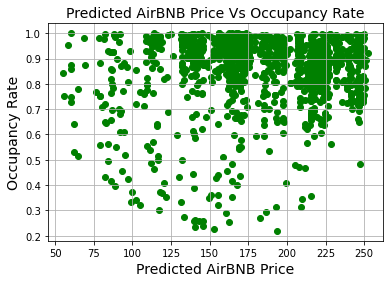

In [121]:
plt.scatter(final_df['Predicted AirBNB Price'], final_df['Occupancy Rate'], color='green')
plt.title('Predicted AirBNB Price Vs Occupancy Rate', fontsize=14)
plt.xlabel('Predicted AirBNB Price', fontsize=14)
plt.ylabel('Occupancy Rate', fontsize=14)
plt.grid(True)
plt.show()

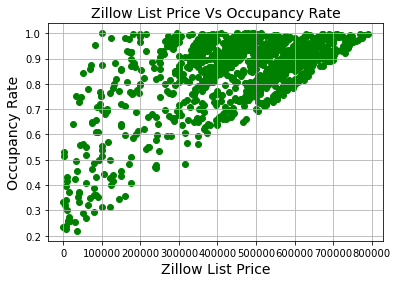

In [122]:
plt.scatter(final_df['Zillow List Price'], final_df['Occupancy Rate'], color='green')
plt.title('Zillow List Price Vs Occupancy Rate', fontsize=14)
plt.xlabel('Zillow List Price', fontsize=14)
plt.ylabel('Occupancy Rate', fontsize=14)
plt.grid(True)
plt.show()

In [123]:
X = final_df[['Predicted AirBNB Price','Zillow List Price']]
Y = final_df['Occupancy Rate']

# with sklearn
regr = LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 1.016554063467006
Coefficients: 
 [-4.85016323e-03  1.60347541e-06]


In [124]:
# prediction with sklearn
Predicted_AirBNB_Price = 300
Zillow_List_Price = 250000
print ('Predicted Occupancy Rate: \n', regr.predict([[Predicted_AirBNB_Price ,Zillow_List_Price]]))

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Predicted Occupancy Rate: 
 [-0.03762605]
                            OLS Regression Results                            
Dep. Variable:         Occupancy Rate   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 1.059e+04
Date:                Mon, 02 May 2022   Prob (F-statistic):               0.00
Time:                        19:19:25   Log-Likelihood:                 2750.9
No. Observations:                1430   AIC:                            -5496.
Df Residuals:                    1427   BIC:                            -5480.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

In [125]:
X = final_df[['Zillow List Price']]
Y = final_df['Occupancy Rate']

# with sklearn
regr = LinearRegression()
regr.fit(X, Y)

print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 0.6262301369957879
Coefficients: 
 [5.29691364e-07]


In [126]:
# prediction with sklearn
Zillow_List_Price = 250000
print ('Predicted Occupancy Rate: \n', regr.predict([[Zillow_List_Price]]))

# with statsmodels
X = sm.add_constant(X) # adding a constant
 
model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 
 
print_model = model.summary()
print(print_model)

Predicted Occupancy Rate: 
 [0.75865298]
                            OLS Regression Results                            
Dep. Variable:         Occupancy Rate   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.348
Method:                 Least Squares   F-statistic:                     762.9
Date:                Mon, 02 May 2022   Prob (F-statistic):          6.63e-135
Time:                        19:19:25   Log-Likelihood:                 1081.8
No. Observations:                1430   AIC:                            -2160.
Df Residuals:                    1428   BIC:                            -2149.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

# Section 4 - Property Recommendations (ROI) <a id='prop_recs'></a>
To return to the top of the notebook, click [here](#home).

Based on airdna, the average property listing in Portland is $136/night and are rented out 82 percent of the time. This predictive recommendation can be tailored, but for this analysis we will use those averages as our benchmarks to determine the 15 best properties available for purchase on Zillow to be turned into an AirBNB property.

Reference: https://www.airdna.co/vacation-rental-data/app/us/oregon/portland/overview

In [127]:
# choose listings that have a breakeven return within one year
top_listings = top_listings_analysis.copy()
top_listings = top_listings_analysis.loc[(top_listings_analysis['Predicted AirBNB Price'] >= 136) & (top_listings_analysis['Predicted AirBNB Price'] <= 137)]
top_listings['Annual Income if Rented Out 82% of the Year)'] = (top_listings['Predicted AirBNB Price'])*300
top_listings = top_listings.sort_values('Predicted AirBNB Price', ascending=False)
print(f'There are {len(top_listings)} properties that meet this criteria.')
top_listings

There are 55 properties that meet this criteria.


,google_address,Predicted AirBNB Price,Zillow List Price,Bathrooms,Bedrooms,Zipcode,Neighborhood,Lat,Long,Cap Rate,Annual Cost,NOI,Annual Income,Occupancy Days,Occupancy Rate,Annual Income if Rented Out 82% of the Year)
1845,2442 Northeast 8th Avenue,136.943906,769500.0,2.0,4.0,97212,Irvington,45.540394,-122.657242,0.1,12000.0,76950.0,88950.0,649.536023,1.779551,41083.171787
3639,3423 Northeast 21st Avenue,136.943906,850000.0,2.0,4.0,97212,Irvington,45.547813,-122.644547,0.1,12000.0,85000.0,97000.0,708.319215,1.940601,41083.171787
3751,3215 Northeast 15th Avenue,136.943906,689000.0,2.0,4.0,97212,Irvington,45.546162,-122.650726,0.1,12000.0,68900.0,80900.0,590.752830,1.618501,41083.171787
6265,3125 Northeast 23rd Avenue,136.943906,590000.0,2.0,4.0,97212,Irvington,45.545586,-122.642448,0.1,12000.0,59000.0,71000.0,518.460457,1.420440,41083.171787
3705,3245 Northeast 15th Avenue,136.943906,731000.0,2.0,4.0,97212,Irvington,45.546574,-122.650719,0.1,12000.0,73100.0,85100.0,621.422322,1.702527,41083.171787
3694,3424 Northeast 17th Avenue,136.943906,730950.0,2.0,4.0,97212,Irvington,45.547825,-122.647980,0.1,12000.0,73095.0,85095.0,621.385811,1.702427,41083.171787
8928,3205 Northeast 18th Avenue,136.943906,650000.0,2.0,4.0,97212,Irvington,45.546013,-122.647598,0.1,12000.0,65000.0,77000.0,562.274016,1.540477,41083.171787
3663,3015 Northeast 19th Avenue,136.943906,805000.0,2.0,4.0,97212,Irvington,45.544605,-122.646591,0.1,12000.0,80500.0,92500.0,675.459045,1.850573,41083.171787
9035,2443 Northeast 8th Avenue,136.943906,612000.0,2.0,4.0,97212,Irvington,45.540398,-122.657867,0.1,12000.0,61200.0,73200.0,534.525428,1.464453,41083.171787
3635,3120 Northeast 22nd Avenue,136.943906,915000.0,2.0,4.0,97212,Irvington,45.545475,-122.642883,0.1,12000.0,91500.0,103500.0,755.783905,2.070641,41083.171787


In [128]:
# export top_listings as a csv
top_listings.to_csv("../Resources/TopListings.csv")
print(f"Top listings were exported to the resources folder.")

Top listings were exported to the resources folder.


To return to the top of the notebook, click [here](#home).